# Feature Engineering

In this notebook I will create many versions of the cleaned data by implementing several strategies for applying scalers, resampling techniques, outlier removal techniques, and PCA.

## Objectives
* Perform Train/Test split
* Perform Scaling
* Perform Resampling
* Remove outliers
* Check for multicolinearity
* PCA

#### Load Data

I will begin by importing the necessary libraries.

In [1]:
# Import Libraries
import numpy as np # arrays
import math
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import zscore, iqr # zscore and interquartile range
from imblearn.over_sampling import SMOTE # SMOTE
from imblearn.under_sampling import NearMiss # Near Miss
from sklearn.decomposition import PCA # Principal component analysis
import time # Record time
import pickle

Now I will load the cleaned data into a pandas dataframe. I will also split the data into independent variables (X) and the dependent variable (y).

In [2]:
# Load data
pickle_in = open("clean_data.pickle", "rb")
df = pickle.load(pickle_in)
pickle_in.close()

# Seperate X and y
X = df.drop('Class', axis=1)
y = df.Class

# Sanity check
print(df.shape)
df.head(3)

(283726, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

Now I will go ahead and save this cleaned data for later use. I will save it in a file called "cleaned_data.pickle" located in the folder called "Modeling" which is located in this directory. I will do this using pickle. Pickle is a tool to save python objects in a binary file.

#### Perform Scaling

In this section I will perform scaling. I will try several techniques for scaling. They are as follows: <br> <br>
1) Use MinMaxScaler on all the columns. <br>
2) Use StandardScaler on all the columns. <br>
3) Use RobustScaler on all the columns. <br>
4) Use a technique I saw on this <a href='https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets'>top rated kaggle post</a> where the person only scales the "Amount" and "Time" columns using robust scaler because the principal component features he assumes are already scaled. I marked his post as source 2. <br><br>
I will fit an instance of each scaler on the data. This Process will make four versions of the data.

I will create a dictionary to hold all the versions of the scaled data.

In [3]:
# Create dictionary to stored scaled versions of the data
scaled_data = {}

My first scaler is MinMaxScaler. This scaler works by squeezing all the data in a feature into a range between 0 and 1. This can transform all the data to be on a very simular scale. The drawback to this scaler is that it is sensitve to outliers. I chose this scaler because it is very popular and ussually effective.

## MinMaxScaler

In [4]:
# Scaling method 1
mms = MinMaxScaler()
X_s1 = mms.fit_transform(X)
X_s1 = pd.DataFrame(X_s1, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s1'] = (X_s1, y)

My second scaler Is StandardScaler. How this scaler works is it takes all of the feature's values and subtracts the feature's mean and then divides by the feature's standard deviation. This scaler is also sensitive to outliers. I chose this scaler because it is very popular and ussually effective.

## StandardScaler

In [5]:
# Scaling method 2
ss = StandardScaler()
X_s2 = ss.fit_transform(X)
X_s2 = pd.DataFrame(X_s2, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s2'] = (X_s2, y)

My third scaler is Robust scaler. "The centering and scaling statistics of this scaler are based on percentiles" (<a href=https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html>Source 3</a>). I Chose this scaler because it is not sensitive to outliers.

## RobustScaler

In [6]:
# Scaling method 3
rs = RobustScaler()
X_s3 = rs.fit_transform(X)
X_s3 = pd.DataFrame(X_s3, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s3'] = (X_s3, y)

My fourth scaling technique I took from the <a href='https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets'>top rated kaggle post</a>. It involves applying Robust scaler to only the "Time" and "Amount" features in this dataset.

In [7]:
# Scaling method 4
rs = RobustScaler()

# Copy X_train and X_test
X_s4 = X.copy()

# Scale "Time" column
X_s4['scaled_time'] = rs.fit_transform(X_s4['Time'].values.reshape(-1,1))

# Drop old "Time" column
X_s4.drop("Time", axis=1, inplace=True)


# Scale "Amount" column
X_s4['scaled_amount'] = rs.fit_transform(X_s4['Amount'].values.reshape(-1,1))

# Drop old "Amount" column
X_s4.drop("Amount", axis=1, inplace=True)

# add data to dictionary ("scaled_data")
scaled_data['s4'] = (X_s4, y)

#### Perform Resampling

In this section I will perform resampling. I will use two techniques. They are as follows: <br><br>
1) SMOTE<br>
2) NearMiss<br><br>
This will give me two new versions of the data for each of the existing versions, giving me a new total of 8 versions of the data. I will add a suffix ("_r1" or "_r2") to each new variable (X and y versions) representing which resampling technique I used. I will also go ahead and create a dictionary to store all the new variables that will be created.

In [8]:
# Create dictionary to store new variables
resampled_data = {}

SMOTE works by taking "samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors." <a href=https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote> Source 4</a>

## SMOTE

In [9]:
# Resampling method 1

# Create an instance of the SMOTE class
sm = SMOTE()

# Declare a suffix that will be added to all the keys
suffix = '_r1'

# Iterate through each of the scaled versions of the data
for key in scaled_data.keys():
    
    # Resample data with smote 
    resampled_X, resampled_y = sm.fit_resample(scaled_data[key][0], scaled_data[key][1])
    
    # turn the X's back into dataframes
    X_r1 = pd.DataFrame(resampled_X, columns=scaled_data[key][0].columns)
    
    # turn y's back into Series
    y_r1 = pd.Series(resampled_y, name='Class')
    
    # add data to the resampled_data dictionary
    resampled_data[key+suffix] = (X_r1, y_r1)

NearMiss also works by using a nearest neighbors approach. In NearMiss the members of the majority class which are nearest to minority class are kept and the rest are removed until the majority and minority classes are of equal size. <a href=https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/>Source 5</a>

## NearMiss

In [10]:
# Resampling method 2

# Create an instance of the NearMiss class
nm = NearMiss()

# Declare a suffix that will be added to all the keys
suffix = '_r2'

# Iterate through each of the scaled versions of the data
for key in scaled_data.keys():
    
    # Resample train data with NearMiss
    resampled_X, resampled_y = nm.fit_resample(scaled_data[key][0], scaled_data[key][1])
    
    # turn the X's' back into dataframes
    X_r2 = pd.DataFrame(resampled_X, columns=scaled_data[key][0].columns)
    
    # turn y's back into Series
    y_r2 = pd.Series(resampled_y, name='Class')
    
    # add data to the resampled_data dictionary
    resampled_data[key+suffix] = (X_r2, y_r2)

In [11]:
# Sanity check
resampled_data.keys()

dict_keys(['s1_r1', 's2_r1', 's3_r1', 's4_r1', 's1_r2', 's2_r2', 's3_r2', 's4_r2'])

#### Remove outliers

Removing outliers has the potential to make a classifier more accurate by removing extreme values, but removing outliers can also be bad for a classifier because information is being removed.

Firstly I will go through all of the different versions of the data and check their columns too see if any one column has a large amount of outliers (over %5). I will do this by creating a function that prints results and then run that function 8 different times, thus checking every version of the data. I will check for outliers using standard deviations from the mean along with the interquartile range method. These methods are described more in depth below. These ways of removing outliers were inspired by this <a href='https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba'>blog post</a> which I noted as source 6.

In [12]:
# Create function
def checkColOutliers(X):
    """
    Takes in a dataframe and prints out the amount of outliers in each column. Also returns a list of tuples
    with the amount of outliers per a column in percent form.
    
    Outliers are defined two ways:
    1) any value in a column that is farther than three standard deviations away from the mean
    2) any value in a column that is farther than four standard deviations away from the mean
    2) any value in a column that is 1.5 interquartile ranges below the 1st quartile or 
    1.5 interquartile ranges above the third quartile
    """
    # List to store amount of outliers in percent form
    ol_percent = []
    
    # Iterate through all of the dataframe's columns
    for col in X.columns:
        
        # record the mean, standard deviation, interquartile range, 1st quartile, and 3rd quartile
        mean_ = X[col].mean()
        std_ = X[col].std()
        iqr_ = iqr(X[col])
        q1 = X[col].quantile(0.25)
        q3 = X[col].quantile(0.75)
        
        # Find outliers
        ol_3std = X[ (X[col] < mean_ - 3*std_) | (X[col] > mean_ + 3*std_) ]
        ol_4std = X[ (X[col] < mean_ - 4*std_) | (X[col] > mean_ + 4*std_) ]
        ol_iqr = X[ (X[col] < q1 - 1.5*iqr_) | (X[col] > q3 + 1.5*iqr_) ]
        
        # Print results
        print("{} has {} values outside 3 standard deviations making up %{}".format(col, len(ol_3std), 100*len(ol_3std)/len(X)))
        print("{} has {} values outside 4 standard deviations making up %{}".format(col, len(ol_4std), 100*len(ol_4std)/len(X)))
        print("{} has {} values outside 1.5 iqrs making up %{}\n".format(col, len(ol_iqr), 100*len(ol_iqr)/len(X)))
        
        # Append results in percent form to ol_percent
        ol_percent.append((col, 100*len(ol_3std)/len(X), 100*len(ol_4std)/len(X), 100*len(ol_iqr)/len(X)))
        
    # Return results
    return ol_percent

In [13]:
# Run the function on each of the 8 versions of the data
for key in resampled_data.keys():
    
    # Print what version of the data it is
    print("\n\n {} \n\n".format(key))
    
    # Run function to check columns for outliers
    # and save results
    results = checkColOutliers(resampled_data[key][0])
    print('\n')
    
    # if a column has over %5 outliers print an alert
    for col, result1, result2, result3 in results:
        if (result1 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((3 STDs))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if (result2 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((4 STDs))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if (result3 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((IQR))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")



 s1_r1 


Time has 0 values outside 3 standard deviations making up %0.0
Time has 0 values outside 4 standard deviations making up %0.0
Time has 0 values outside 1.5 iqrs making up %0.0

V1 has 17015 values outside 3 standard deviations making up %3.0034986390258887
V1 has 9086 values outside 4 standard deviations making up %1.6038665080334542
V1 has 50169 values outside 1.5 iqrs making up %8.855863839041422

V2 has 16194 values outside 3 standard deviations making up %2.8585751960261674
V2 has 6209 values outside 4 standard deviations making up %1.0960166353048335
V2 has 49456 values outside 1.5 iqrs making up %8.73000462484069

V3 has 19893 values outside 3 standard deviations making up %3.511525032391537
V3 has 4678 values outside 4 standard deviations making up %0.8257635400154633
V3 has 46399 values outside 1.5 iqrs making up %8.190381037447088

V4 has 5908 values outside 3 standard deviations making up %1.0428839235595033
V4 has 4 values outside 4 standard deviations making up 

V2 has 15883 values outside 3 standard deviations making up %2.8036772779105603
V2 has 6247 values outside 4 standard deviations making up %1.102724419511885
V2 has 48606 values outside 1.5 iqrs making up %8.579962083367166

V3 has 19569 values outside 3 standard deviations making up %3.4543323459945703
V3 has 4993 values outside 4 standard deviations making up %0.8813675406791808
V3 has 46992 values outside 1.5 iqrs making up %8.2950577752045

V4 has 6002 values outside 3 standard deviations making up %1.0594768634401048
V4 has 4 values outside 4 standard deviations making up %0.0007060825481106996
V4 has 10635 values outside 1.5 iqrs making up %1.8772969747893227

V5 has 19322 values outside 3 standard deviations making up %3.4107317486487347
V5 has 6930 values outside 4 standard deviations making up %1.223288014601787
V5 has 70416 values outside 1.5 iqrs making up %12.429877176940757

V6 has 5460 values outside 3 standard deviations making up %0.963802678171105
V6 has 976 values out

V1 has 16675 values outside 3 standard deviations making up %2.943481622436479
V1 has 8905 values outside 4 standard deviations making up %1.571916272731445
V1 has 50658 values outside 1.5 iqrs making up %8.942182430547955

V2 has 16065 values outside 3 standard deviations making up %2.8358040338495973
V2 has 5992 values outside 4 standard deviations making up %1.057711657069828
V2 has 49496 values outside 1.5 iqrs making up %8.737065450321797

V3 has 19713 values outside 3 standard deviations making up %3.4797513177265555
V3 has 4702 values outside 4 standard deviations making up %0.8300000353041274
V3 has 48467 values outside 1.5 iqrs making up %8.55542571482032

V4 has 6398 values outside 3 standard deviations making up %1.129379035703064
V4 has 4 values outside 4 standard deviations making up %0.0007060825481106996
V4 has 11098 values outside 1.5 iqrs making up %1.959026029733136

V5 has 19075 values outside 3 standard deviations making up %3.3671311513028988
V5 has 6860 values out

V2 has 16015 values outside 3 standard deviations making up %2.8269780019982136
V2 has 5974 values outside 4 standard deviations making up %1.05453428560333
V2 has 47649 values outside 1.5 iqrs making up %8.411031833731682

V3 has 19495 values outside 3 standard deviations making up %3.441269818854522
V3 has 4938 values outside 4 standard deviations making up %0.8716589056426587
V3 has 46911 values outside 1.5 iqrs making up %8.280759603605258

V4 has 5881 values outside 3 standard deviations making up %1.0381178663597561
V4 has 4 values outside 4 standard deviations making up %0.0007060825481106996
V4 has 10807 values outside 1.5 iqrs making up %1.9076585243580828

V5 has 19361 values outside 3 standard deviations making up %3.417616053492814
V5 has 6569 values outside 4 standard deviations making up %1.1595640646347964
V5 has 70430 values outside 1.5 iqrs making up %12.432348465859144

V6 has 5401 values outside 3 standard deviations making up %0.9533879605864721
V6 has 948 values ou

V3 has 32 values outside 3 standard deviations making up %3.382663847780127
V3 has 9 values outside 4 standard deviations making up %0.9513742071881607
V3 has 88 values outside 1.5 iqrs making up %9.30232558139535

V4 has 17 values outside 3 standard deviations making up %1.7970401691331923
V4 has 0 values outside 4 standard deviations making up %0.0
V4 has 26 values outside 1.5 iqrs making up %2.748414376321353

V5 has 31 values outside 3 standard deviations making up %3.2769556025369977
V5 has 12 values outside 4 standard deviations making up %1.2684989429175475
V5 has 128 values outside 1.5 iqrs making up %13.530655391120508

V6 has 11 values outside 3 standard deviations making up %1.1627906976744187
V6 has 3 values outside 4 standard deviations making up %0.3171247357293869
V6 has 61 values outside 1.5 iqrs making up %6.4482029598308666

V7 has 20 values outside 3 standard deviations making up %2.1141649048625792
V7 has 7 values outside 4 standard deviations making up %0.739957716

V1 has 28 values outside 3 standard deviations making up %2.959830866807611
V1 has 14 values outside 4 standard deviations making up %1.4799154334038056
V1 has 85 values outside 1.5 iqrs making up %8.985200845665961

V2 has 29 values outside 3 standard deviations making up %3.06553911205074
V2 has 11 values outside 4 standard deviations making up %1.1627906976744187
V2 has 88 values outside 1.5 iqrs making up %9.30232558139535

V3 has 34 values outside 3 standard deviations making up %3.5940803382663846
V3 has 10 values outside 4 standard deviations making up %1.0570824524312896
V3 has 86 values outside 1.5 iqrs making up %9.090909090909092

V4 has 17 values outside 3 standard deviations making up %1.7970401691331923
V4 has 0 values outside 4 standard deviations making up %0.0
V4 has 29 values outside 1.5 iqrs making up %3.06553911205074

V5 has 33 values outside 3 standard deviations making up %3.488372093023256
V5 has 12 values outside 4 standard deviations making up %1.2684989429175

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V19 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V20 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V21 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V22 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V23 HAS OVER 

V28 has 28 values outside 3 standard deviations making up %2.959830866807611
V28 has 6 values outside 4 standard deviations making up %0.6342494714587738
V28 has 175 values outside 1.5 iqrs making up %18.49894291754757

scaled_time has 0 values outside 3 standard deviations making up %0.0
scaled_time has 0 values outside 4 standard deviations making up %0.0
scaled_time has 0 values outside 1.5 iqrs making up %0.0

scaled_amount has 24 values outside 3 standard deviations making up %2.536997885835095
scaled_amount has 11 values outside 4 standard deviations making up %1.1627906976744187
scaled_amount has 123 values outside 1.5 iqrs making up %13.002114164904862



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V1 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
V2 HAS OVER %5 OUTLIERS ((IQR))
!!!!!!!!

It seems that a lot of columns have too many outliers when using the interquartile range method, and this is true for all 8 versions of the data. So I will have two strategies for removing outliers and they are as follows: <br><br>
1) Don't remove any outliers  <br>
2) Remove rows containing a value that is more than three standard deviations away from that value's column's mean <br>
3) Remove rows containing a value that is more than four standard deviations away from that value's column's mean<br><br>
I will do method two and three by finding outliers in each column and recording there indices and then drop all the outlier containing indices from that data's train data. All together removing outliers will give me 24 versions of the data which I will store in a new dictionary called "outlier_removed_data".

In [14]:
# Create new dictionary for the 16 versions of data
outlier_removed_data = {}

In [15]:
# Remove outliers method 1 (Don't remove outliers)

# Create a suffix for outlier removal method 1
suffix = '_o1'

# Iterate through all the previous versions data
for key in resampled_data.keys():
        
        # add suffix and copy data to new dictionary ("outlier_removed_data")
        outlier_removed_data[key + suffix] = resampled_data[key]

In [16]:
# Remove outliers method 2

# Create a suffix for outlier removal method 2
suffix = '_o2'

# Iterate through all the previous versions of data
for key in resampled_data.keys():


    # Copy data
    new_X = resampled_data[key][0].copy()
    new_y = resampled_data[key][1].copy()

    # Create list to store indices to drop per column
    col_indices = []

    # Create list of all indices to drop
    indices = []

    # Iterate through each column
    for col in new_X.columns:

        # Record columns mean and std
        mean_ = new_X[col].mean()
        std_ = new_X[col].std()
    
        # Append column's outlier indices to the indices list
        # outlier is any value more than three stardard deviations from its column's mean
        col_indices.append(new_X[ (new_X[col] < mean_ - 3*std_) | (new_X[col] > mean_ + 3*std_) ].index)

    # Take values from col_indices and form them into one list
    for list_ in col_indices:
        for item in list_:
            indices.append(item)
        
    # Set indices equal to its unique values
    indices = list(set(indices))
        
    # Drop all rows with outliers
    new_X = new_X.drop(indices, axis=0)
    new_y = new_y.drop(indices, axis=0)
    
    # Raise an error if the lengths do not match
    if len(new_X) != len(new_y):
        print("!"*40)
        print("Error")
        print("!"*40)

    # Add suffix and add new data to dictionary ("outlier_removed_data")
    outlier_removed_data[key + suffix] = (new_X, new_y)
        
    # Print out how much of the data was kept
    print(key)
    print("{} rows out of {} were dropped".format(len(indices), len(resampled_data[key][0])))
    print("%{} of the data was kept\n\n".format(100*len(new_X)/len(resampled_data[key][0])))


s1_r1
88653 rows out of 566506 were dropped
%84.35091596558554 of the data was kept


s2_r1
91826 rows out of 566506 were dropped
%83.79081598429673 of the data was kept


s3_r1
92793 rows out of 566506 were dropped
%83.62012052829097 of the data was kept


s4_r1
92082 rows out of 566506 were dropped
%83.74562670121765 of the data was kept


s1_r2
165 rows out of 946 were dropped
%82.55813953488372 of the data was kept


s2_r2
168 rows out of 946 were dropped
%82.24101479915433 of the data was kept


s3_r2
164 rows out of 946 were dropped
%82.66384778012684 of the data was kept


s4_r2
162 rows out of 946 were dropped
%82.8752642706131 of the data was kept




Outlier removal method 2 removed too much data and should not be used. I will remove all versions of the data invloving outlier removal method 2 from the dictionary (outlier_removed_data). After all is said and done I should have 16 versions of the data.

In [17]:
# Remove all instances of the data which used outlier removal technique 2
for key in sorted(outlier_removed_data.keys()):
    if key.endswith('o2'):
        del outlier_removed_data[key]

In [18]:
# Remove outliers method 3

# Create a suffix for outlier removal method 2
suffix = '_o3'

# Iterate through all the previous versions of the data
for key in resampled_data.keys():


    # Copy data
    new_X = resampled_data[key][0].copy()
    new_y = resampled_data[key][1].copy()

    # Create list to store indices to drop per column
    col_indices = []

    # Create list of all indices to drop
    indices = []

    # Iterate through each column
    for col in new_X.columns:

        # Record columns mean and std
        mean_ = new_X[col].mean()
        std_ = new_X[col].std()
    
        # Append column's outlier indices to the indices list
        # outlier is any value more than three stardard deviations from its column's mean
        col_indices.append(new_X[ (new_X[col] < mean_ - 4*std_) | (new_X[col] > mean_ + 4*std_) ].index)

    # Take values from col_indices and form them into one list
    for list_ in col_indices:
        for item in list_:
            indices.append(item)
        
    # Set indices equal to its unique values
    indices = list(set(indices))
        
    # Drop all rows with outliers
    new_X = new_X.drop(indices, axis=0)
    new_y = new_y.drop(indices, axis=0)
    
    # Raise an error if the lengths do not match
    if len(new_X) != len(new_y):
        print("!"*40)
        print("Error")
        print("!"*40)

    # Add suffix and add new data to dictionary ("outlier_removed_data")
    outlier_removed_data[key + suffix] = (new_X, new_y)
        
    # Print out how much of the data was kept
    print(key)
    print("{} rows out of {} were dropped".format(len(indices), len(resampled_data[key][0])))
    print("%{} of the data was kept\n\n".format(100*len(new_X)/len(resampled_data[key][0])))


s1_r1
25225 rows out of 566506 were dropped
%95.5472669309769 of the data was kept


s2_r1
27175 rows out of 566506 were dropped
%95.20305168877293 of the data was kept


s3_r1
27969 rows out of 566506 were dropped
%95.06289430297296 of the data was kept


s4_r1
27286 rows out of 566506 were dropped
%95.18345789806287 of the data was kept


s1_r2
50 rows out of 946 were dropped
%94.71458773784356 of the data was kept


s2_r2
52 rows out of 946 were dropped
%94.5031712473573 of the data was kept


s3_r2
53 rows out of 946 were dropped
%94.39746300211416 of the data was kept


s4_r2
51 rows out of 946 were dropped
%94.60887949260042 of the data was kept




Outlier removal method 3 can remove up to around %6 of the data, but I wil still try it out to see if it imporves performance.

Now I will check the value counts of the new versions of the data and see how they compare with the original data's value counts.

In [19]:
# Check value counts for outlier removal method 3
for key in outlier_removed_data.keys():
    if key.endswith('o3'):
        print(key)
        print(outlier_removed_data[key][1].value_counts(normalize=True))
        print('\n\n')

s1_r1_o3
0    0.511411
1    0.488589
Name: Class, dtype: float64



s2_r1_o3
0    0.513334
1    0.486666
Name: Class, dtype: float64



s3_r1_o3
0    0.514559
1    0.485441
Name: Class, dtype: float64



s4_r1_o3
0    0.513794
1    0.486206
Name: Class, dtype: float64



s1_r2_o3
0    0.523438
1    0.476562
Name: Class, dtype: float64



s2_r2_o3
0    0.527964
1    0.472036
Name: Class, dtype: float64



s3_r2_o3
0    0.529675
1    0.470325
Name: Class, dtype: float64



s4_r2_o3
0    0.527374
1    0.472626
Name: Class, dtype: float64





The data is still well balanced.

#### Check for multicolinarity

In this section I will create plots to show the multicolinarity of all the variables in each version of the data. I will write a function to do this.

## Seaborn

In [20]:
# Function to plot heatmaps
def drawHeatMap(d, key):
    
    # Get X and y
    X = d[key][0]
    y = d[key][1]
    
    # Concatenate X and y into a dataframe
    df = pd.concat([X, y], axis=1)
    
    # Draw colored heatmap showing correlation values
    plt.figure(figsize=(20,20))
    sns.heatmap(round(df.corr(), 2), cmap='coolwarm', annot=True)
    plt.title(key)
    plt.show()
    
    print('\n\n')

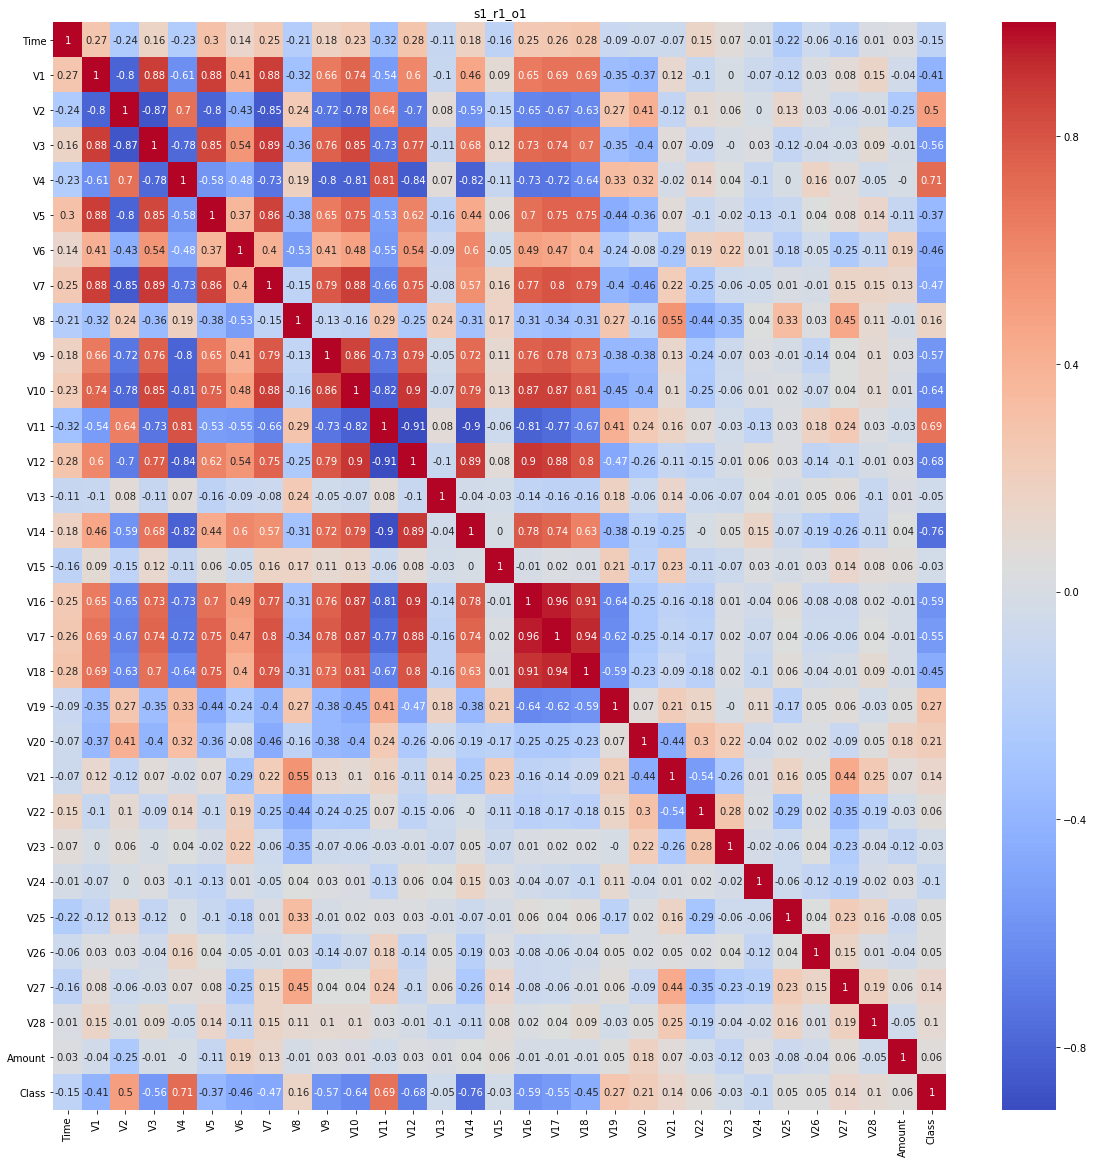

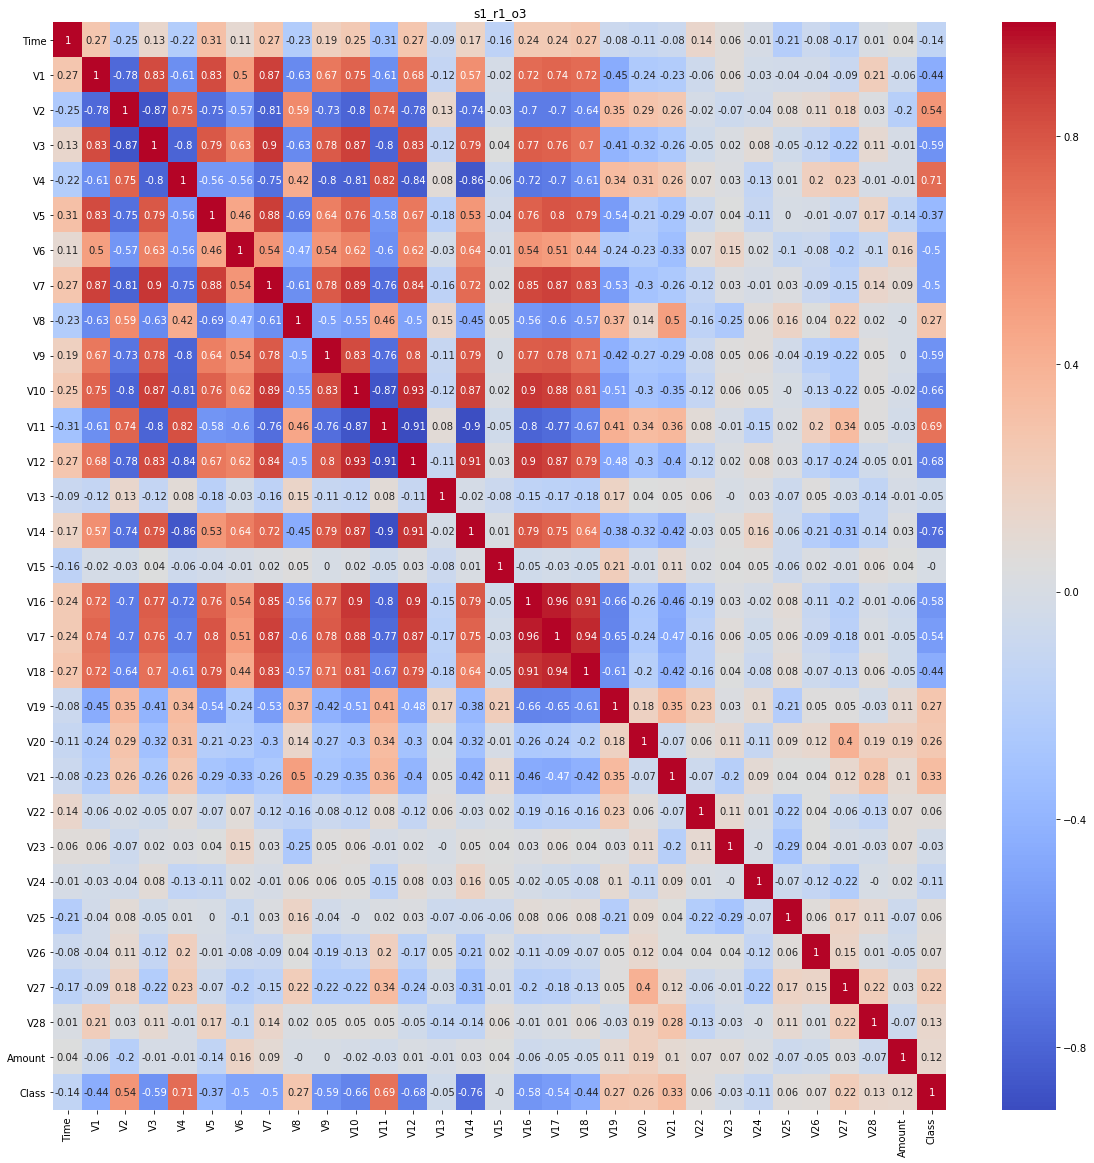

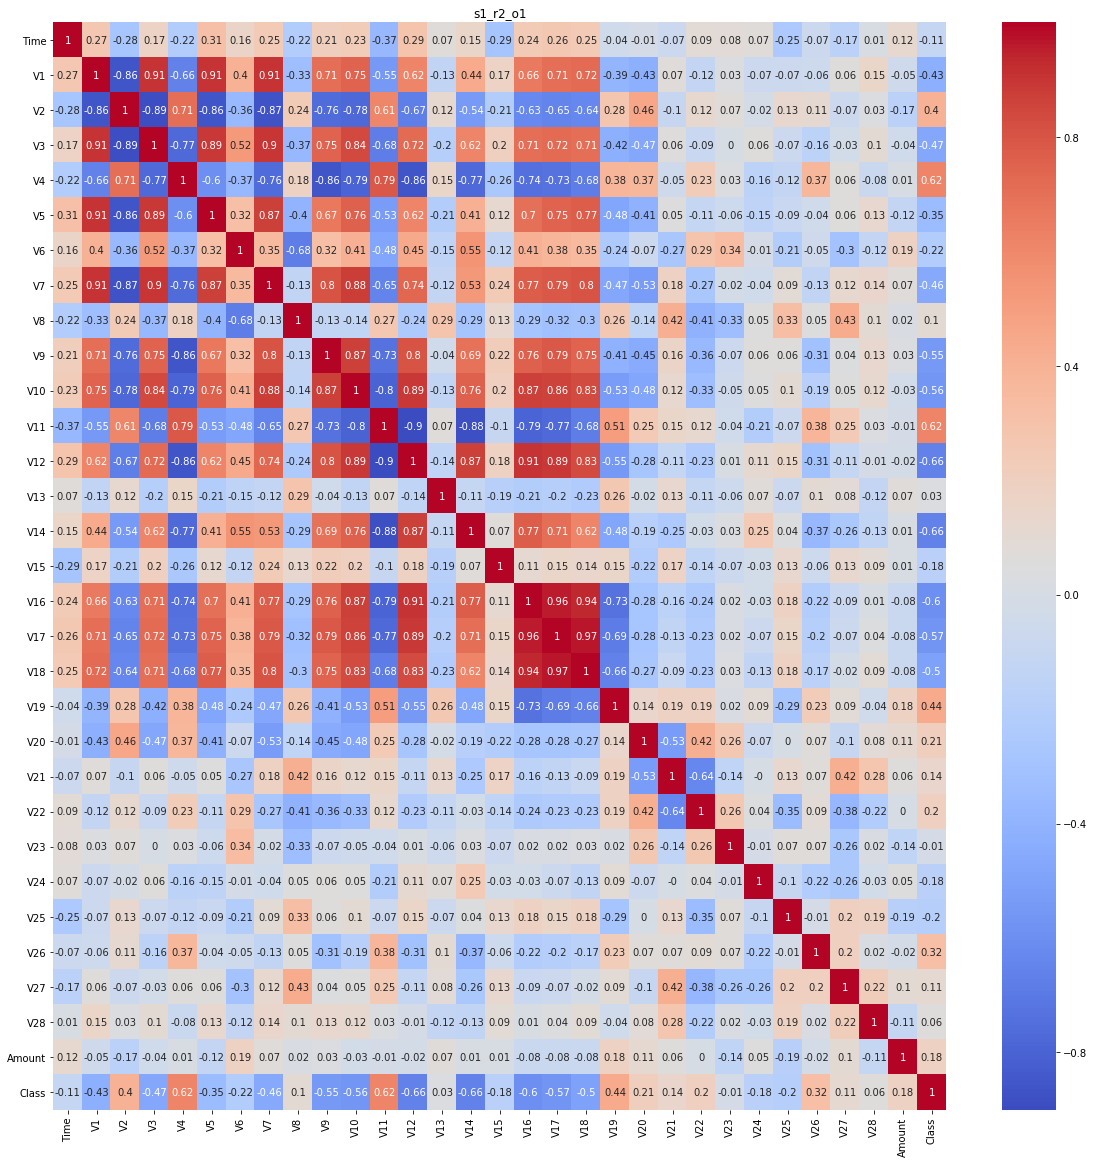

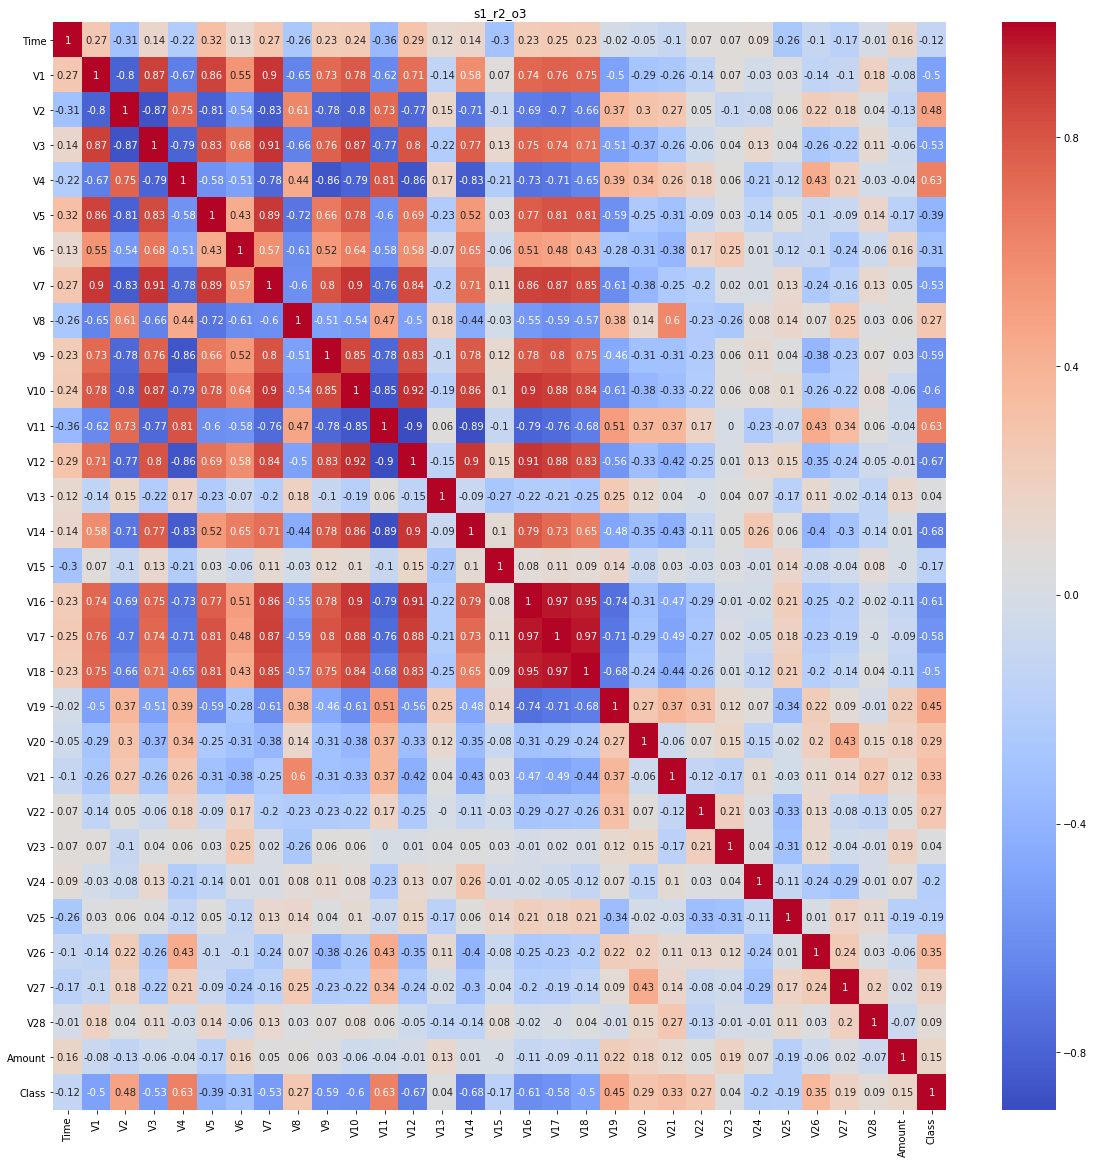

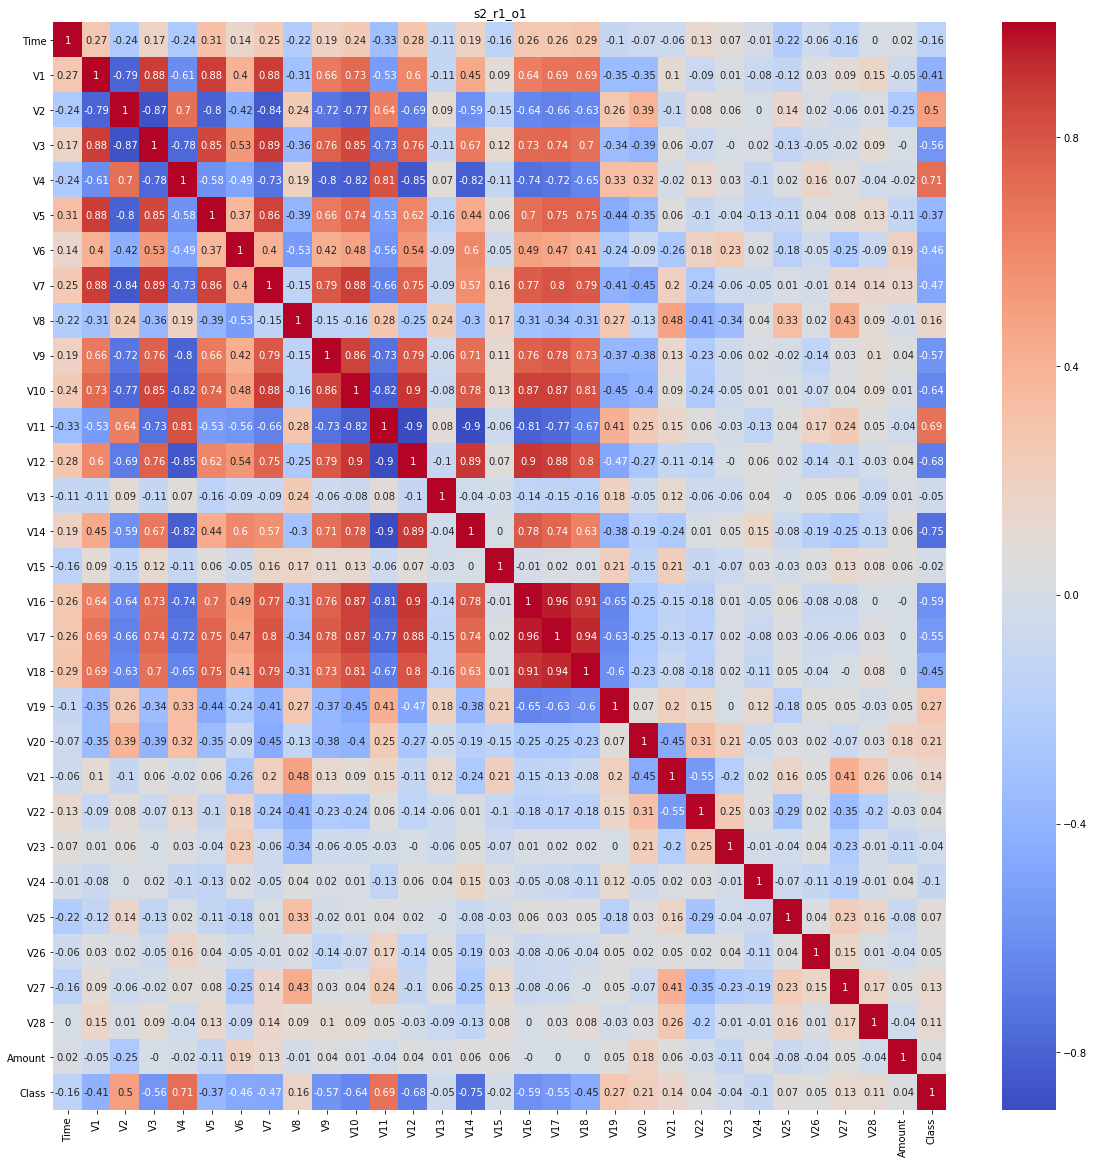

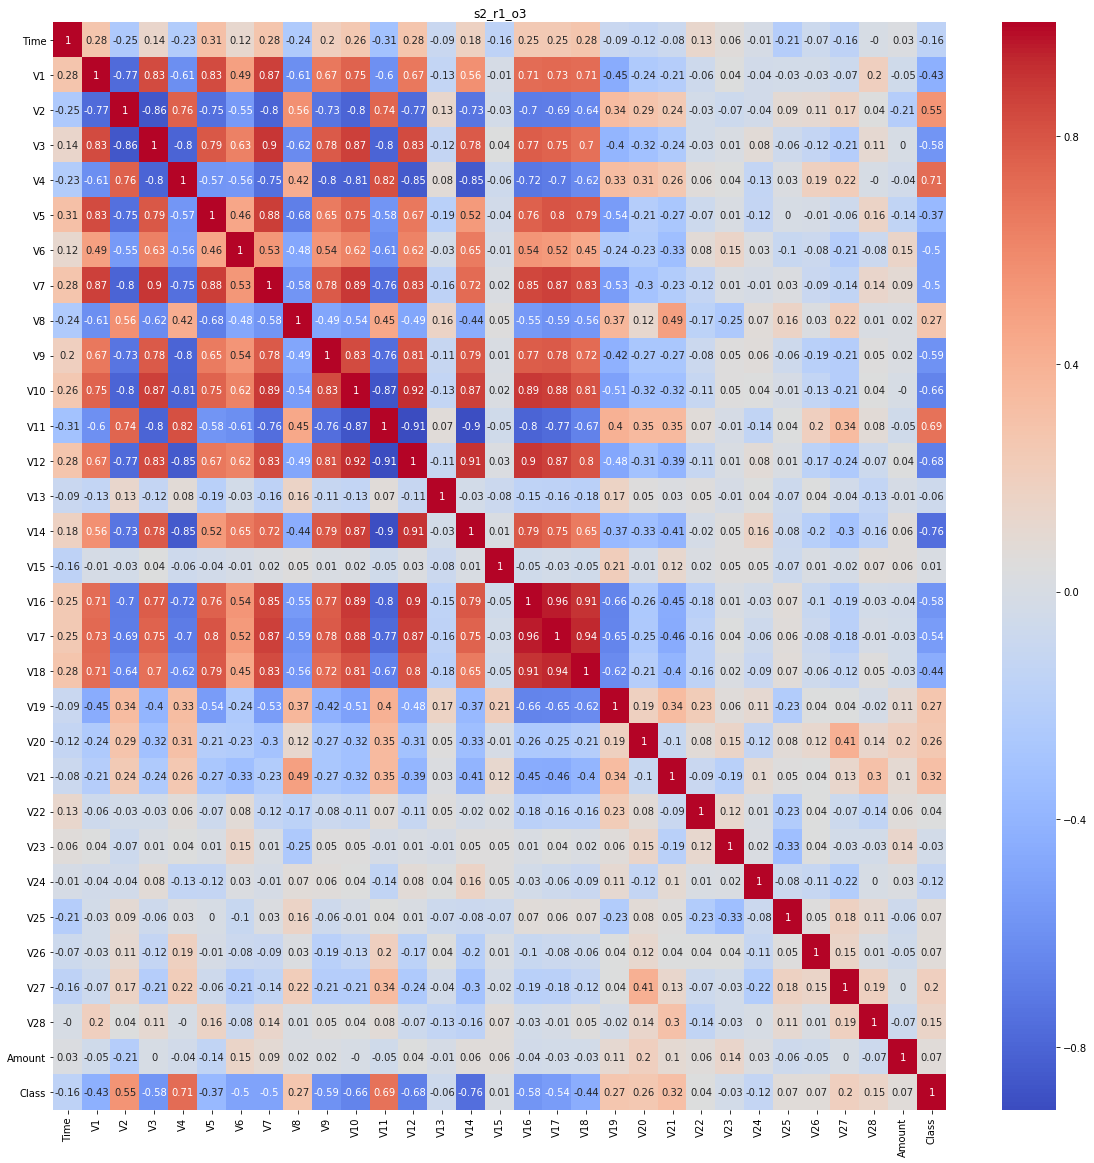

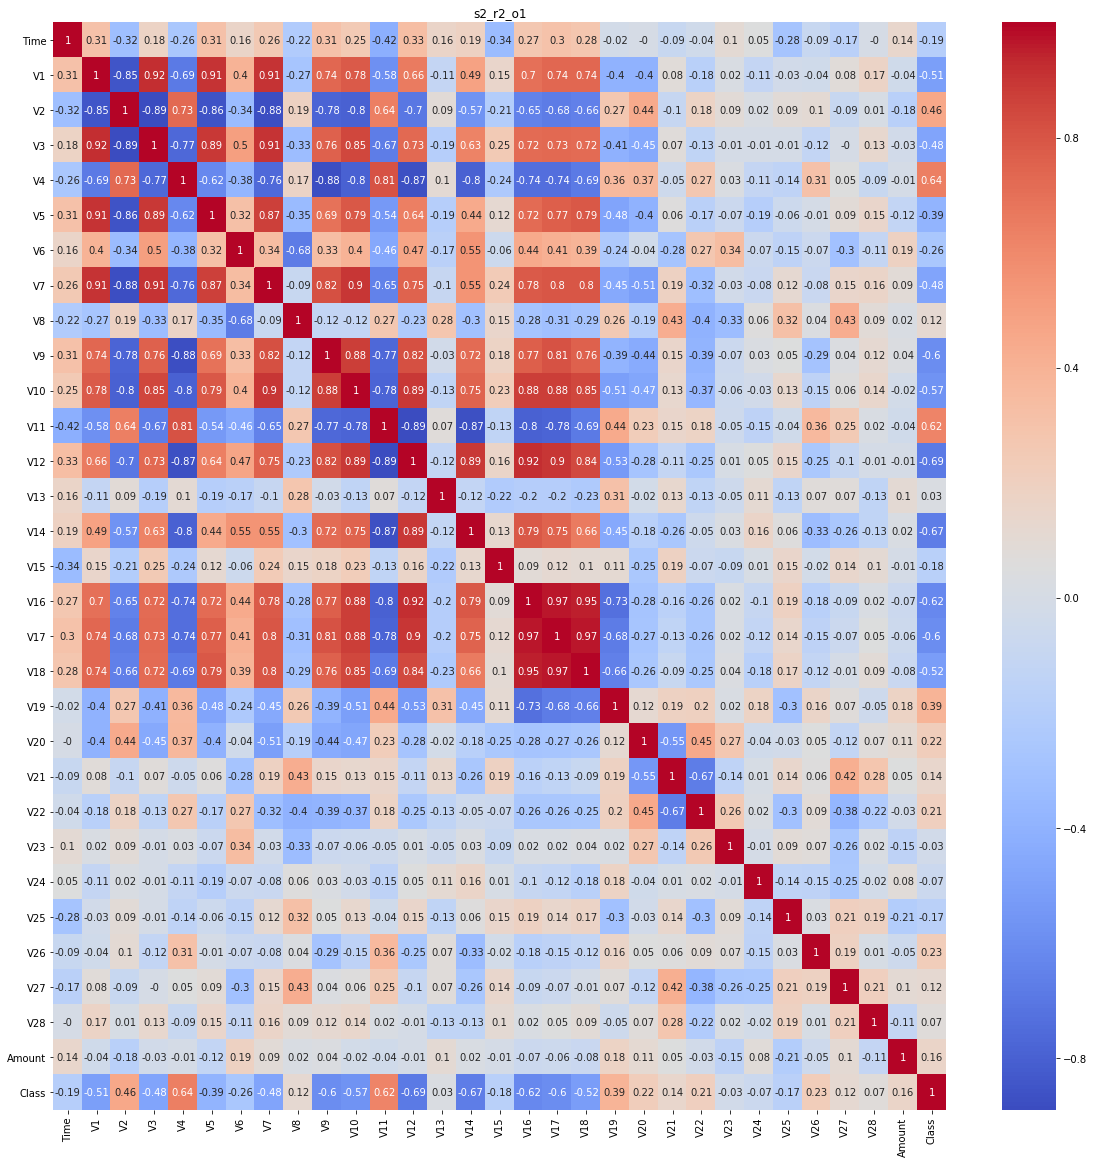

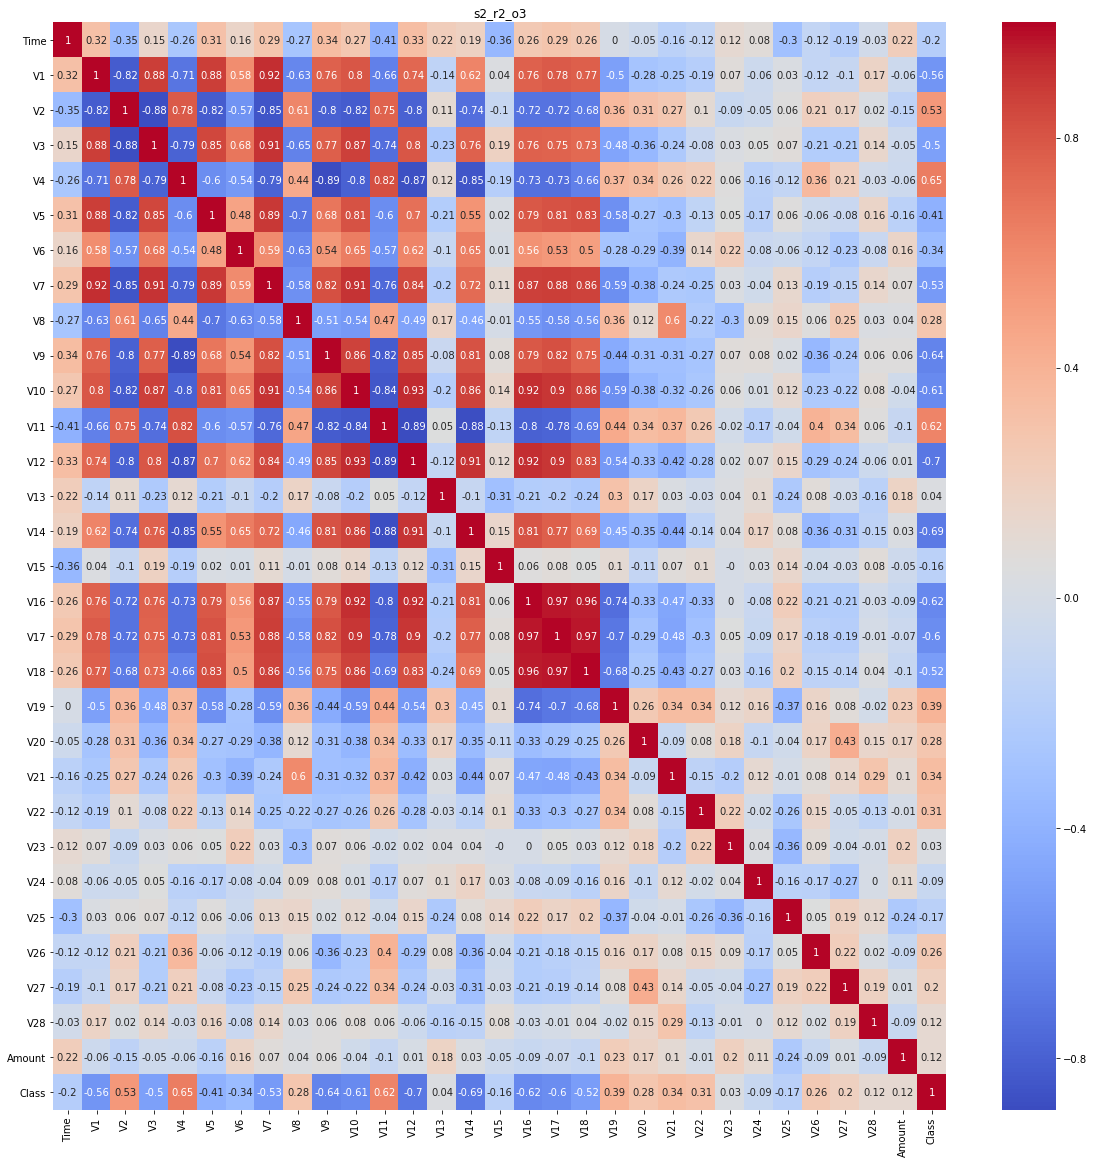

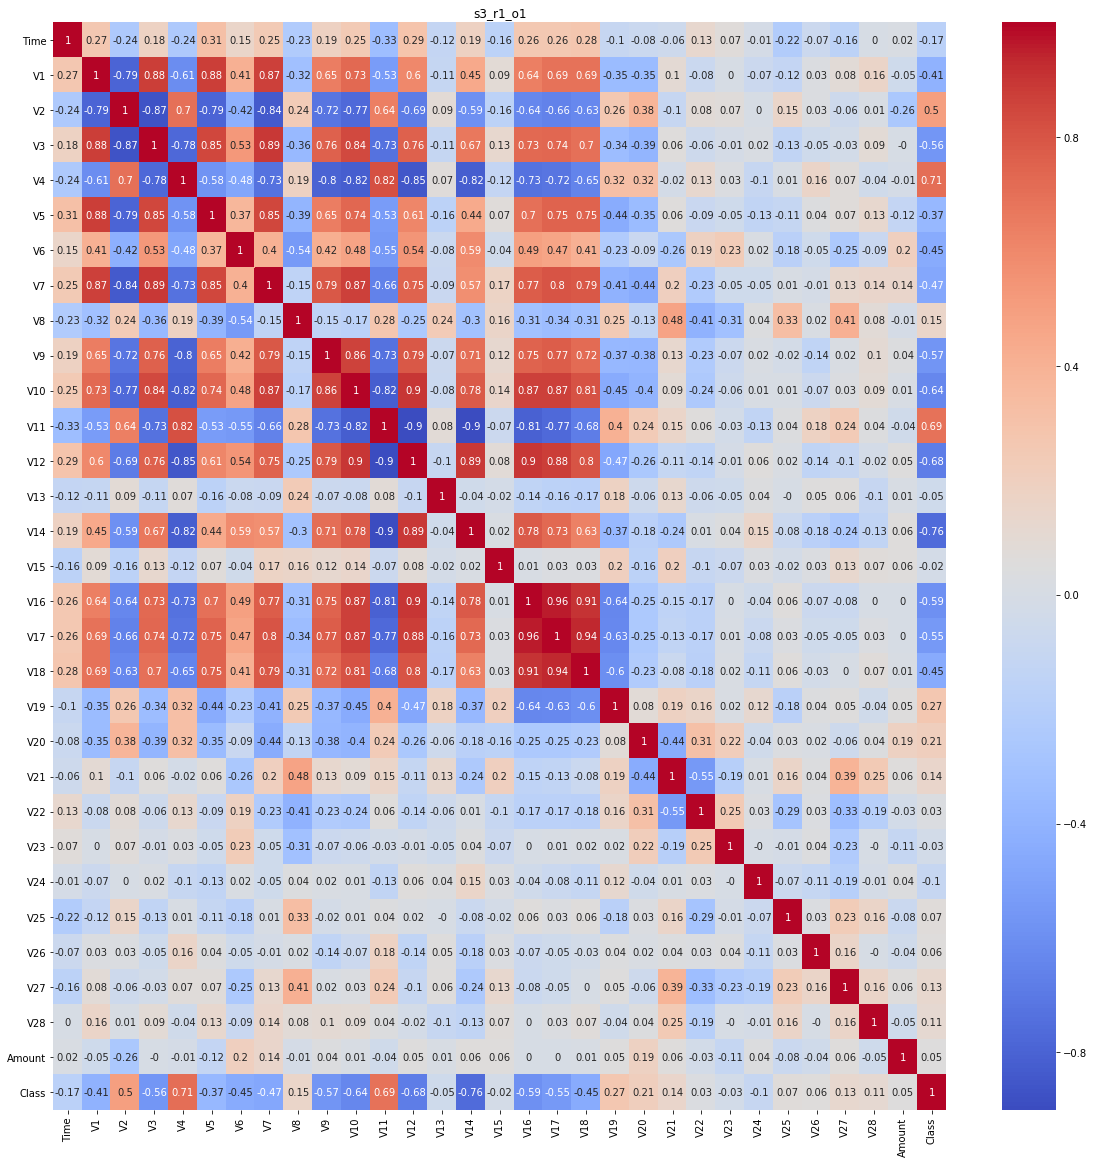

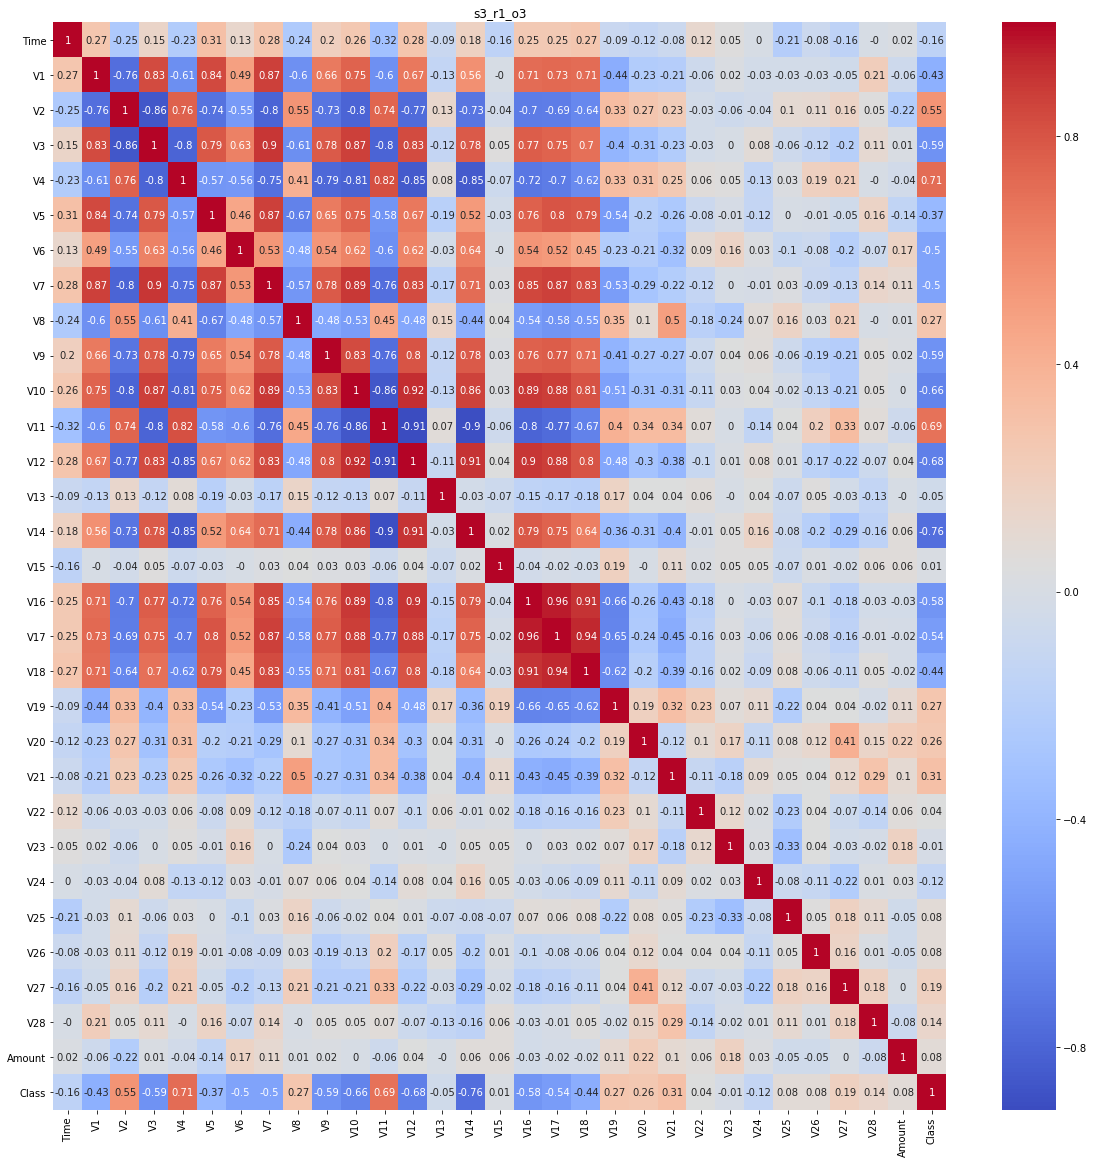

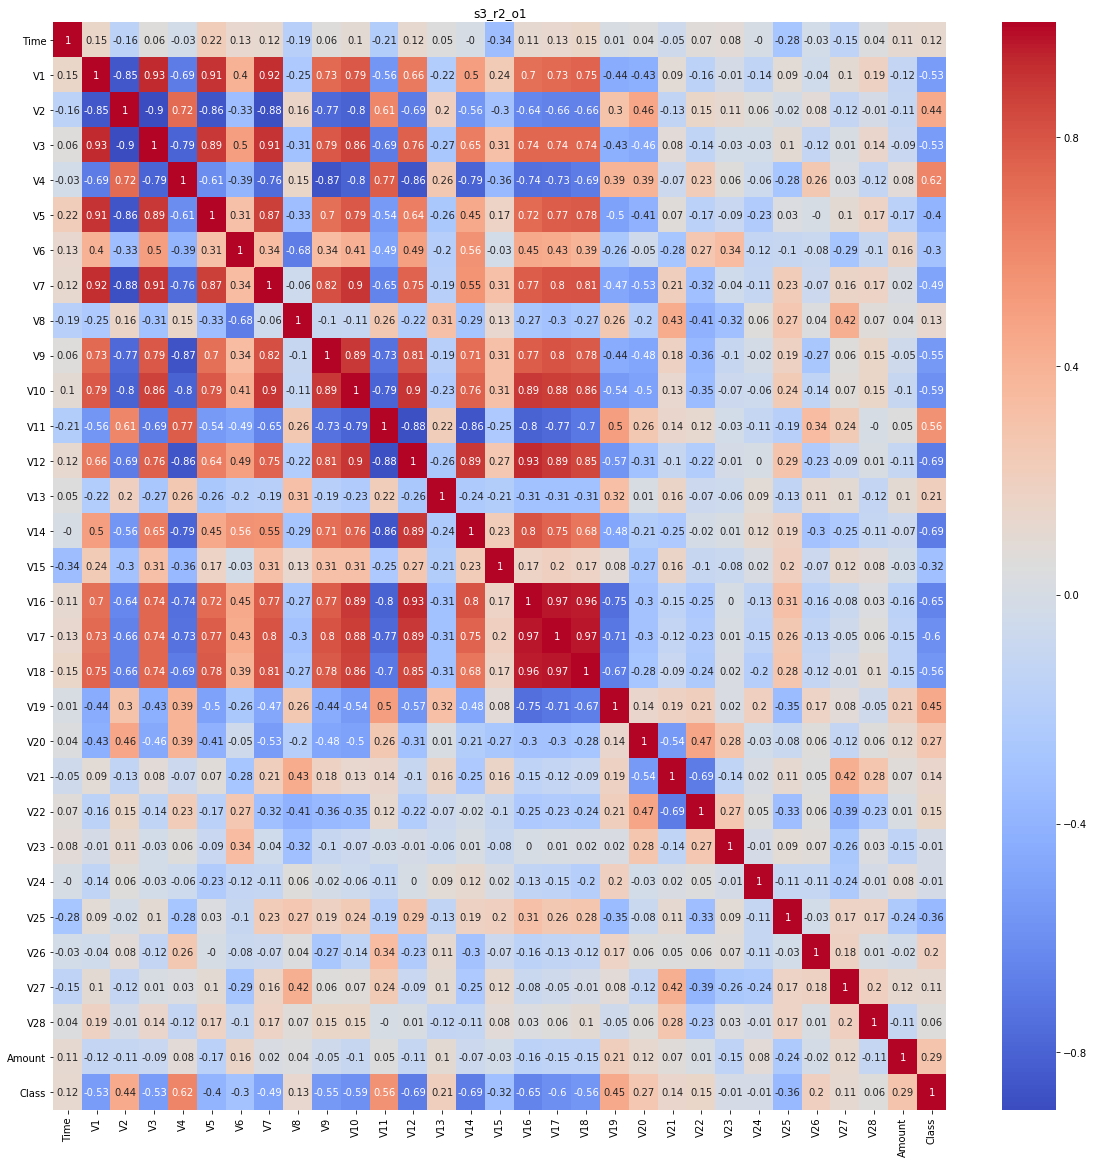

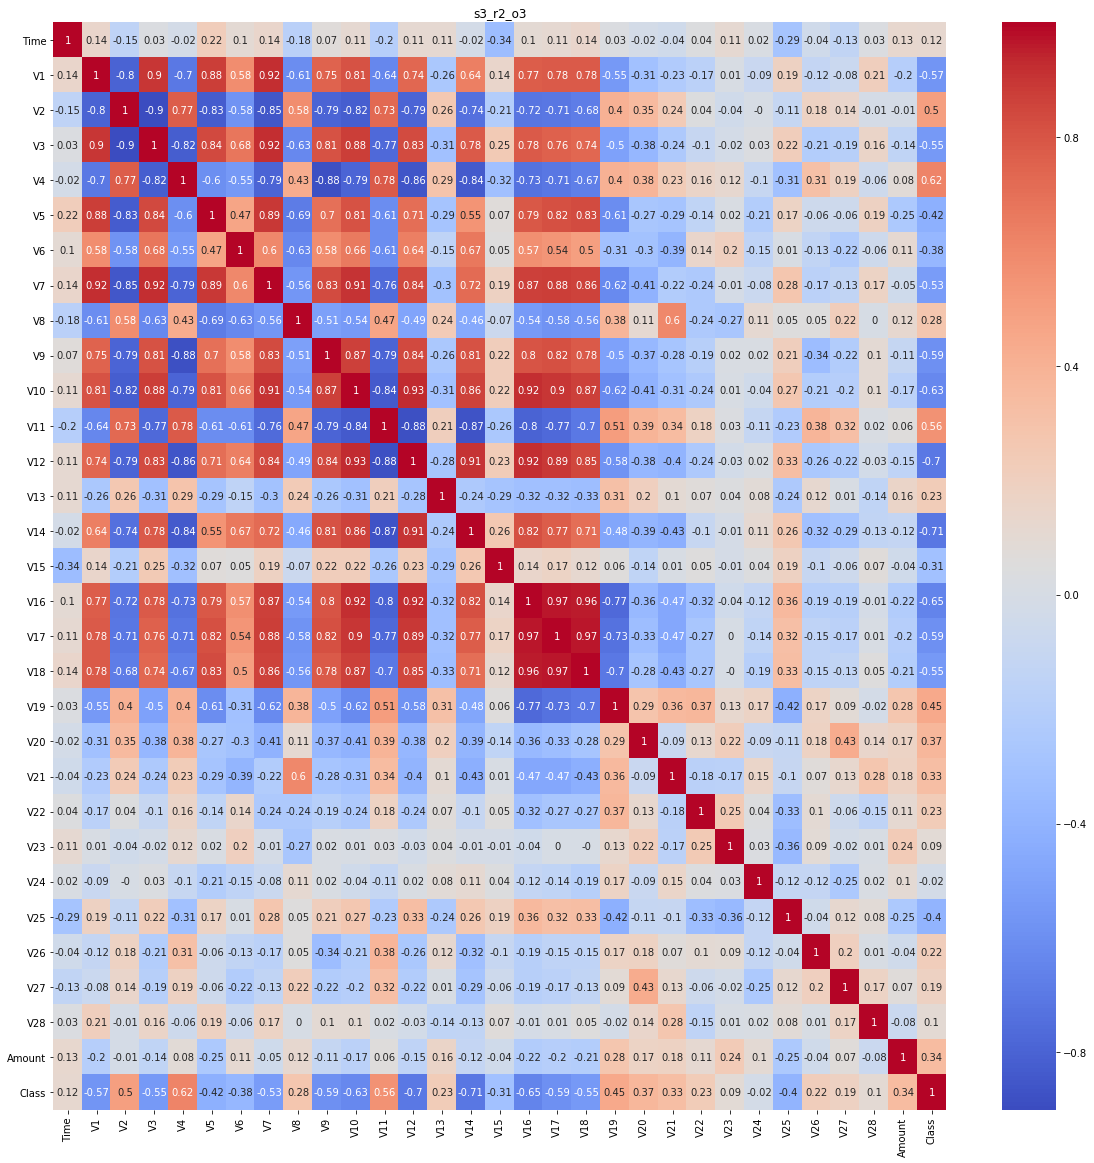

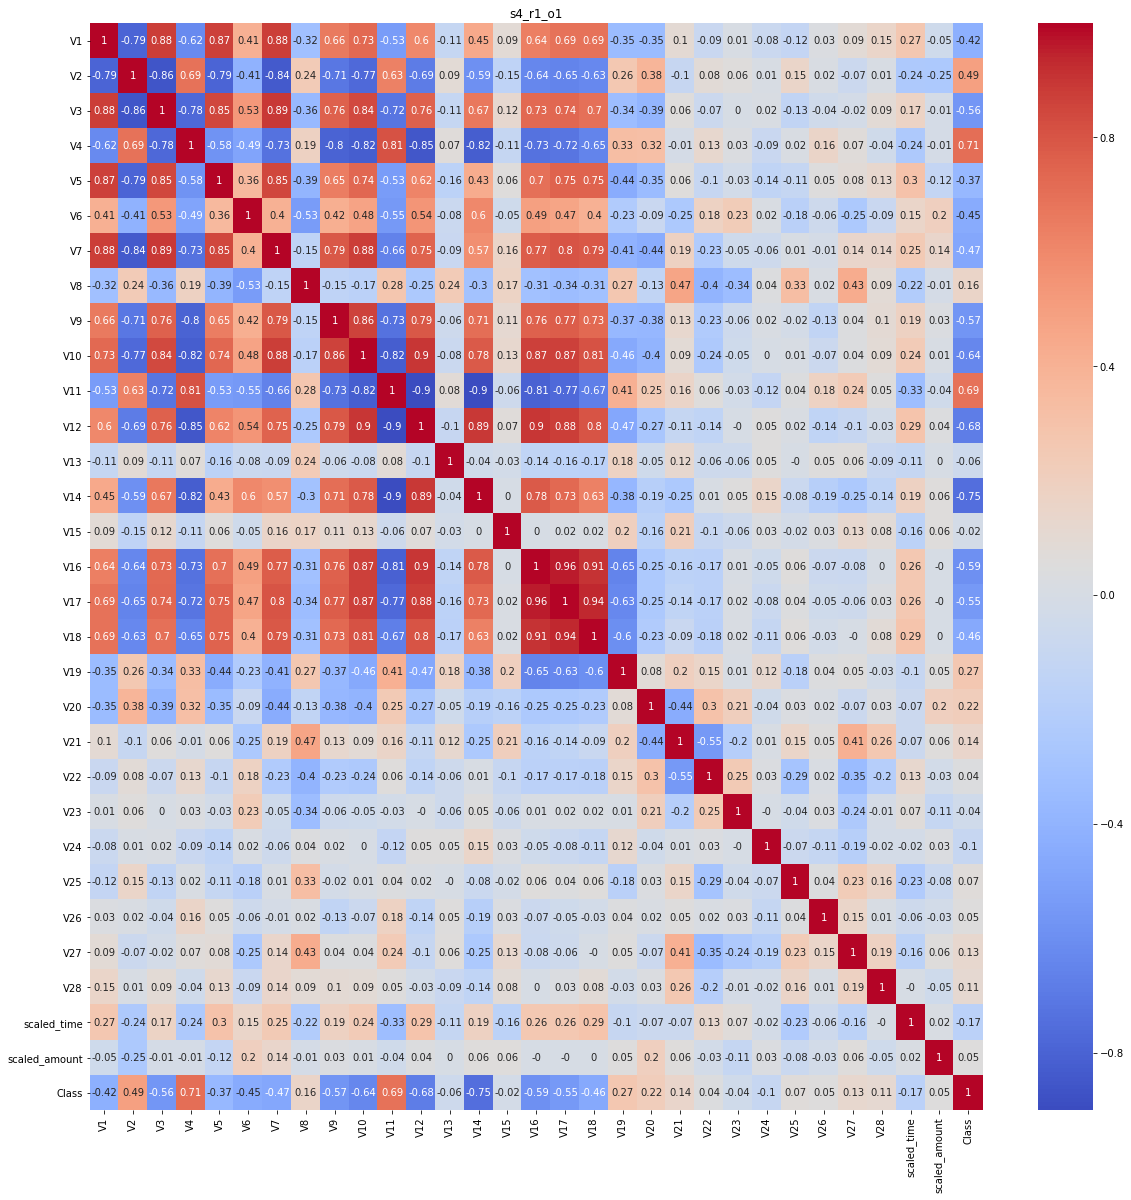

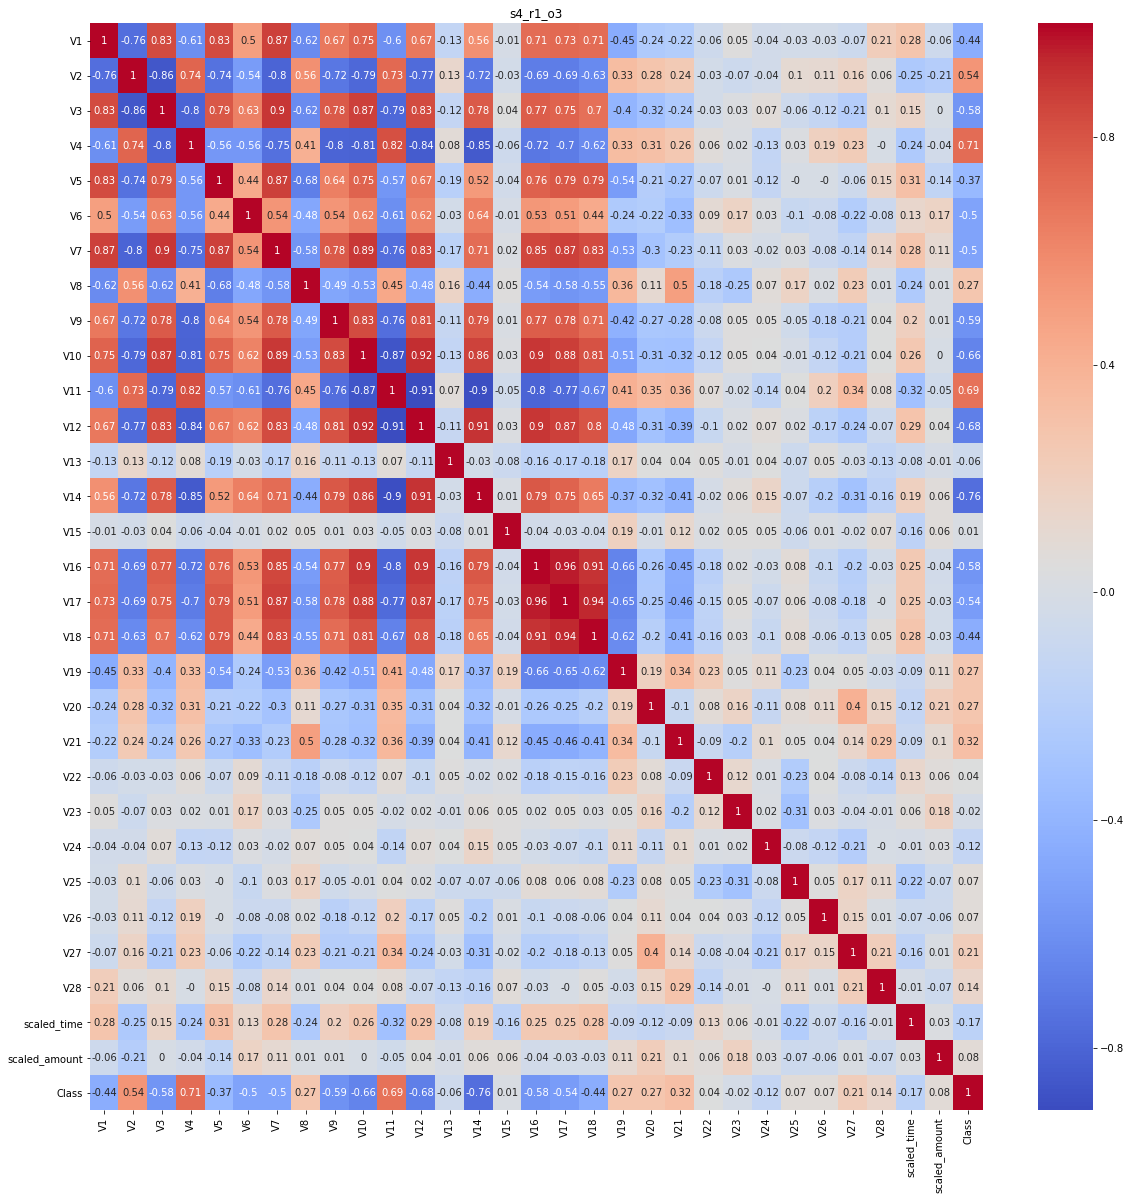

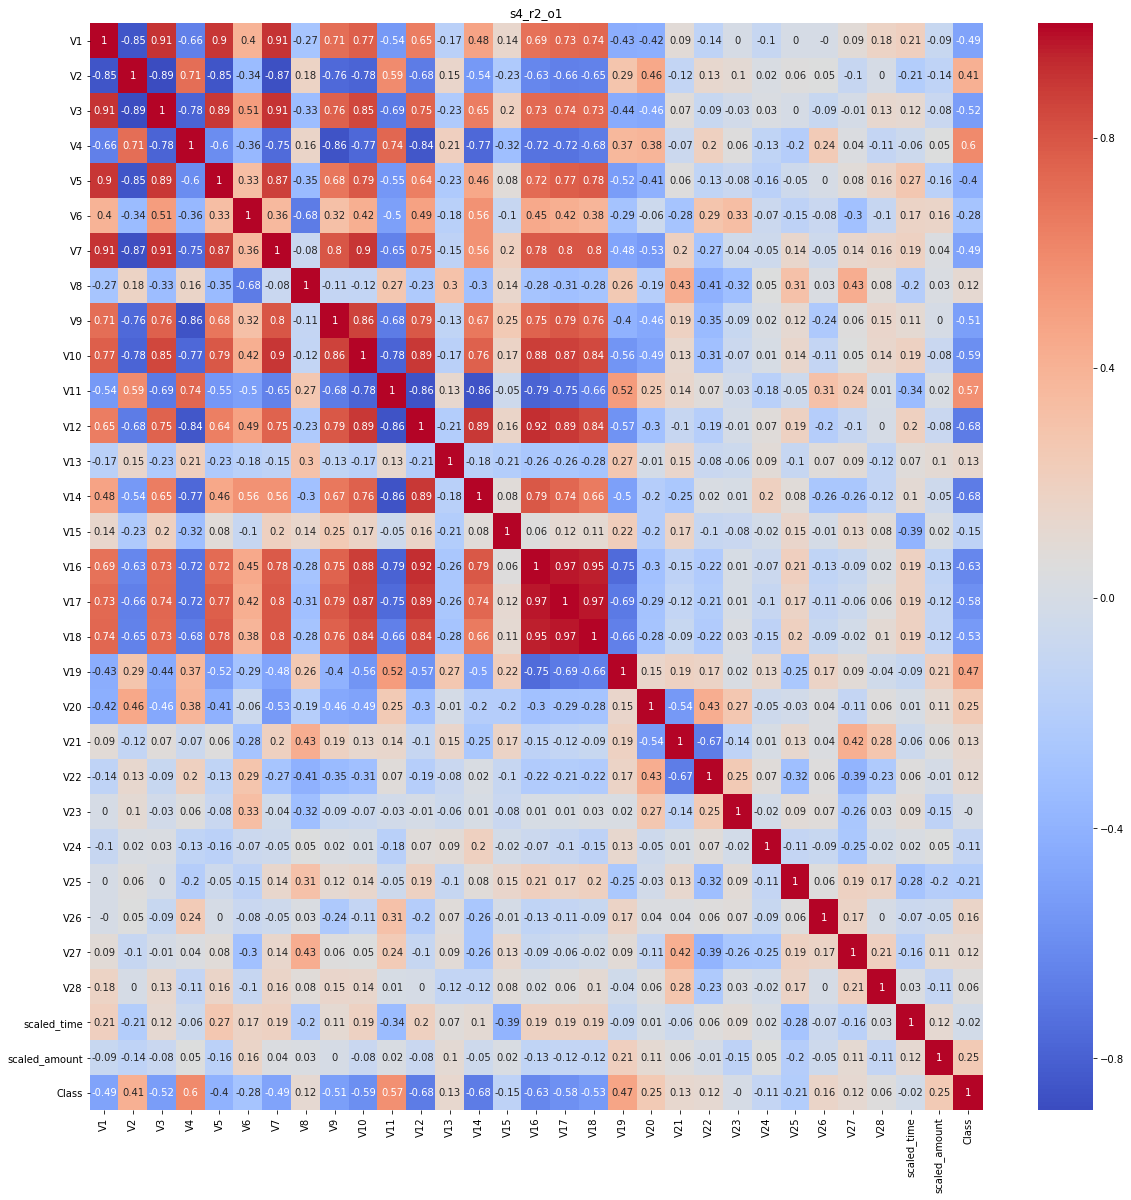

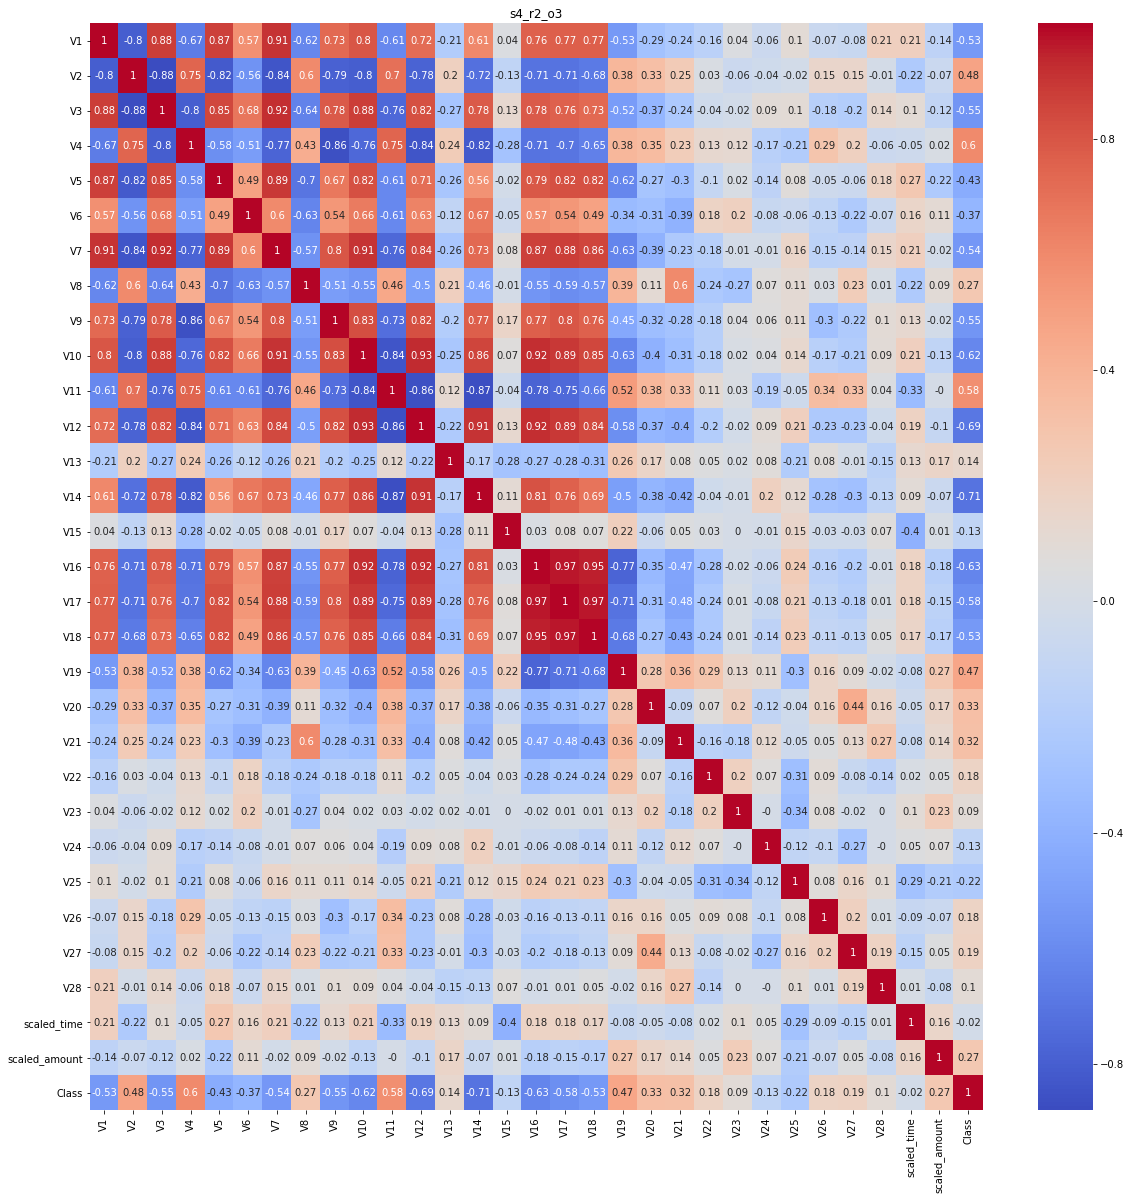

In [21]:
# Plot heatmaps for each version of the data
for key in sorted(outlier_removed_data.keys()):
    drawHeatMap(outlier_removed_data, key)

All versions of the data have multicolinarity. I will try to fix this with PCA.

#### Principal component analysis

In this section I will perform PCA on each of the 16 versions of the data. My process for each version of the data will be as follows: <br><br>
1) Create a range from 1 to the amount of total features minus 1 (29). <br>
2) Create an instance of the PCA class for each number in the range with the number of components set to the before mentioned number. <br>
4) Fit each PCA instance to the data. <br>
5) Find the sum of the total explained variance for each PCA instance. <br>
6) Plot the results <br>
7) Examine plots to see where they platue and select that many components.<br>
8) Record a list of components for each version of the data

I will be writing a function to do steps 1 through 6.

## PCA

## Matplotlib

In [22]:
# Function for steps 1 - 8
def PCA_Plot(key):
    
    # Get X
    X_= outlier_removed_data[key][0]
    
    # Create list to store sums of explained variance ratios
    evrs = []
    
    # Create a range from 1 to 29
    r = range(5,30)
    
    # Create an instance of the PCA class for each number in r
    for n in r:
        pca = PCA(n)
        
        # Fit pca to the data and transform
        X_pca = pca.fit_transform(X_)

        # Append the sum of explained variance ratio to the list "evrs"
        evrs.append(sum(pca.explained_variance_ratio_))
        
    # Plot the results
    plt.figure(figsize=(15,4))
    plt.plot(r, evrs, color='green', label='Sums of explained variance ratios')
    plt.title(key + ' Explained variance')
    plt.xlabel('Number of principle components')
    plt.xticks(r)
    plt.yticks(np.array(np.arange(round(evrs[0], 1)-0.1, 1.09, step=0.1)))
    plt.legend()
    plt.grid()
    plt.show()
    

Now I will manually go through each version and record where each graph plateus. I will use a list to record my observations.

Warning: this cell took 8 minutes to run!

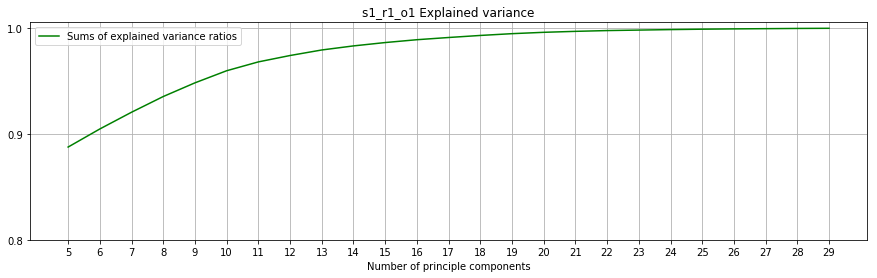

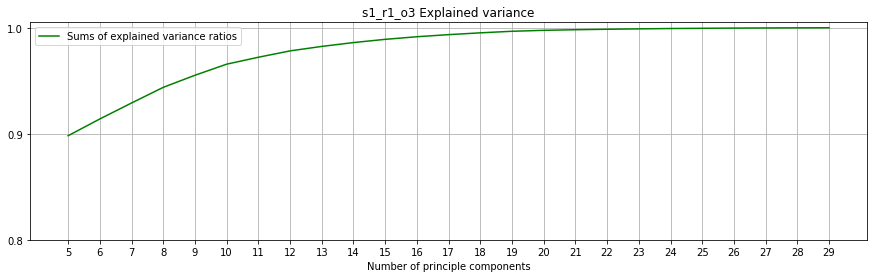

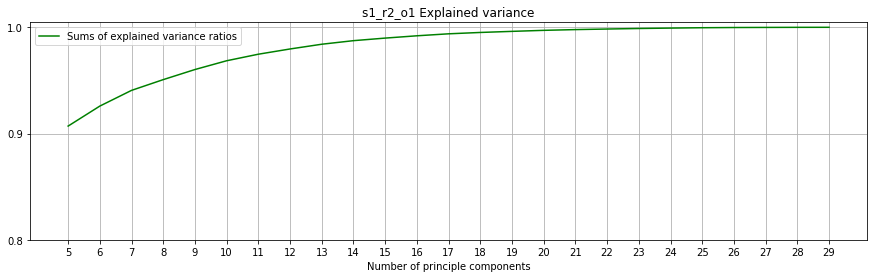

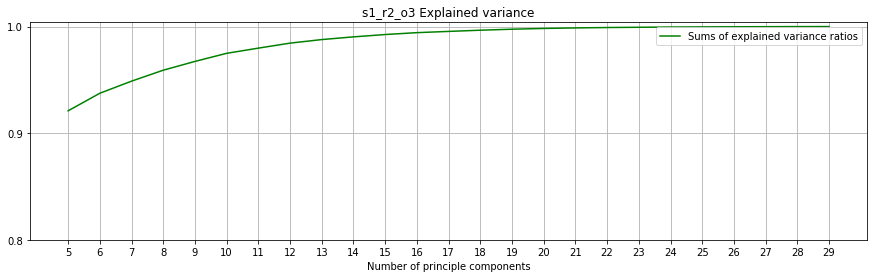

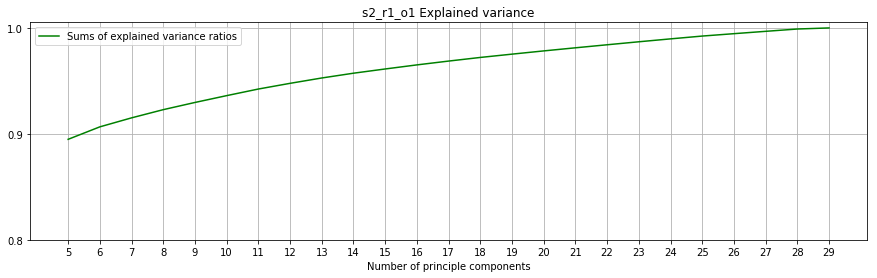

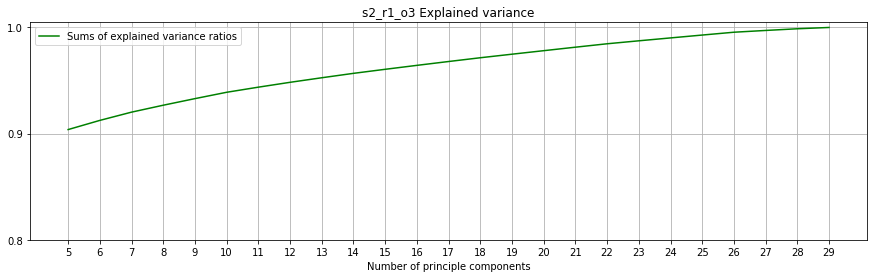

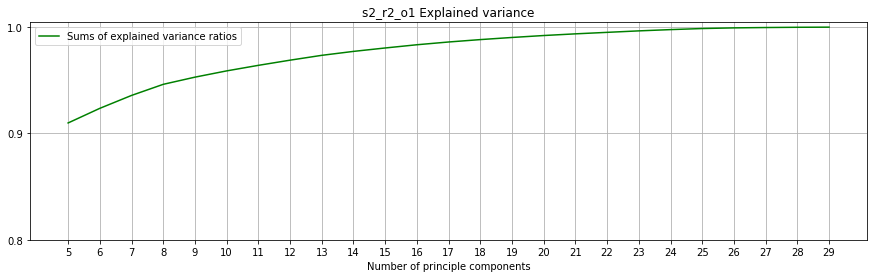

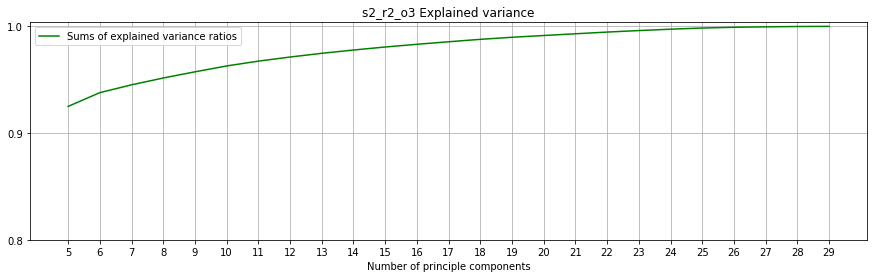

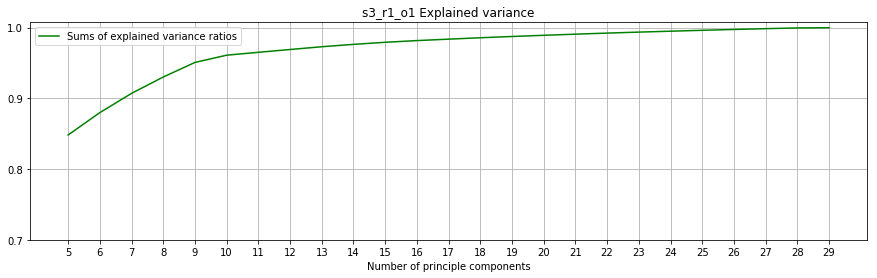

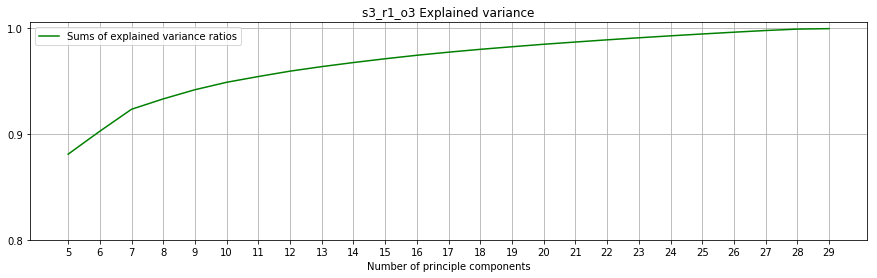

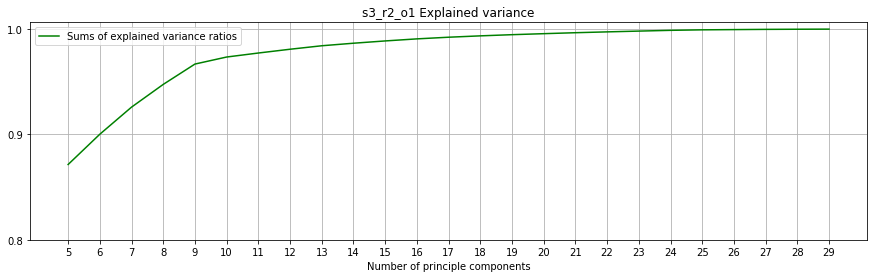

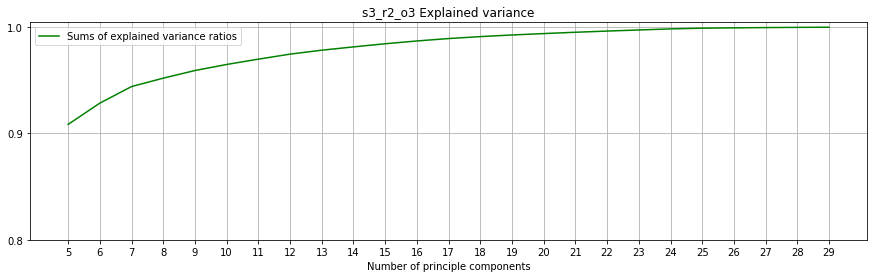

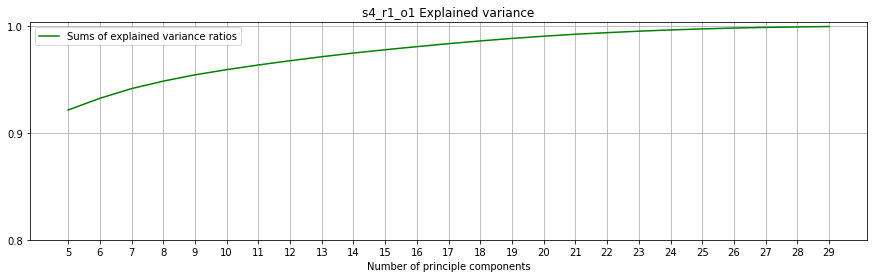

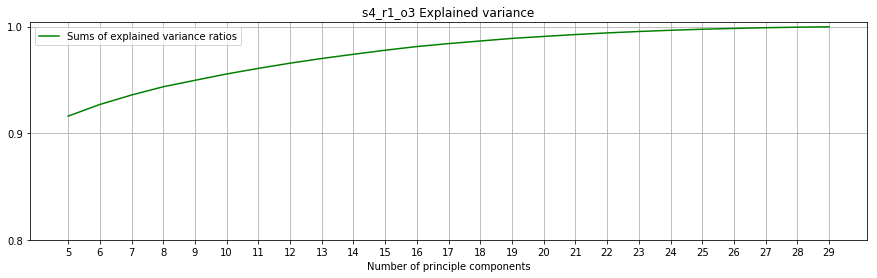

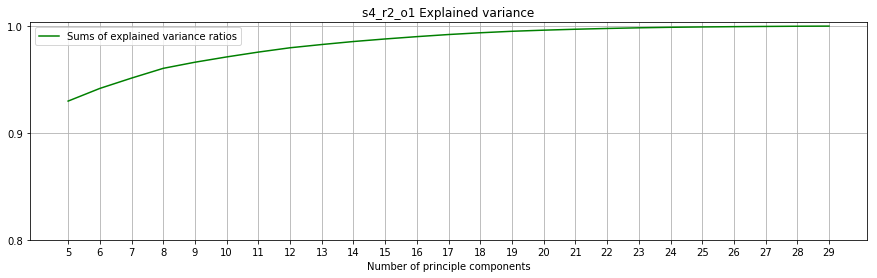

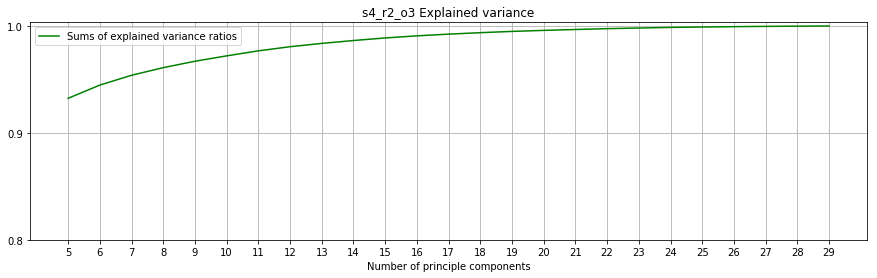

It took 808.3191134929657 seconds for this cell to run


In [23]:
# Run function on every version of the data and time this cell

t1 = time.time()

for key in sorted(outlier_removed_data.keys()):
    PCA_Plot(key)
    
t2 = time.time()

print('It took {} seconds for this cell to run'.format(t2-t1))

In [24]:
# Number of components to use in order of sorted keys
n_components = [16, 16, 16, 15, 24, 25, 19, 20, 23, 24, 19, 18, 21, 22, 16, 18]

# zip sorted keys of outlier removed data with n_components
olr_keys_n_components = zip(sorted(outlier_removed_data.keys()), n_components)

In [25]:
# Save olr_keys_n_components
pickle_out = open("Modeling/olr_keys_n_components.pickle", "wb")
pickle.dump(olr_keys_n_components, pickle_out)
pickle_out.close()

Now for each key in outlier_removed_data I will create a key in a new dictionary (pc_data) where I will store a PCA transformed version of the train and test data. I will add a suffix '_p' to the data just in case to help keep things organized.

In [26]:
# Dictionary for PCA transformed data
pc_data = {}

In [27]:
# Create a suffix to add to each key
suffix = '_p'

# Iterate through our list of n_components and through the sorted keys of outlier_removed_data
for key, n in olr_keys_n_components:
    
    # Retrieve data from outlier_removed_data
    X_ = outlier_removed_data[key][0]
    y_ = outlier_removed_data[key][1]
    
    # Create an instance of the PCA class with the right amount for n_components
    pca = PCA(n)
    
    # fit and transform data
    pc_X = pca.fit_transform(X_)
    
    # Turn data back into a dataframe
    pc_X = pd.DataFrame(pc_X, columns=range(n))

    
    # Add the newly transformed data too the dictionary pc_data
    pc_data[key + suffix] = (pc_X, y_)

Now I will examine the PCA transformed data for multicolinearity.

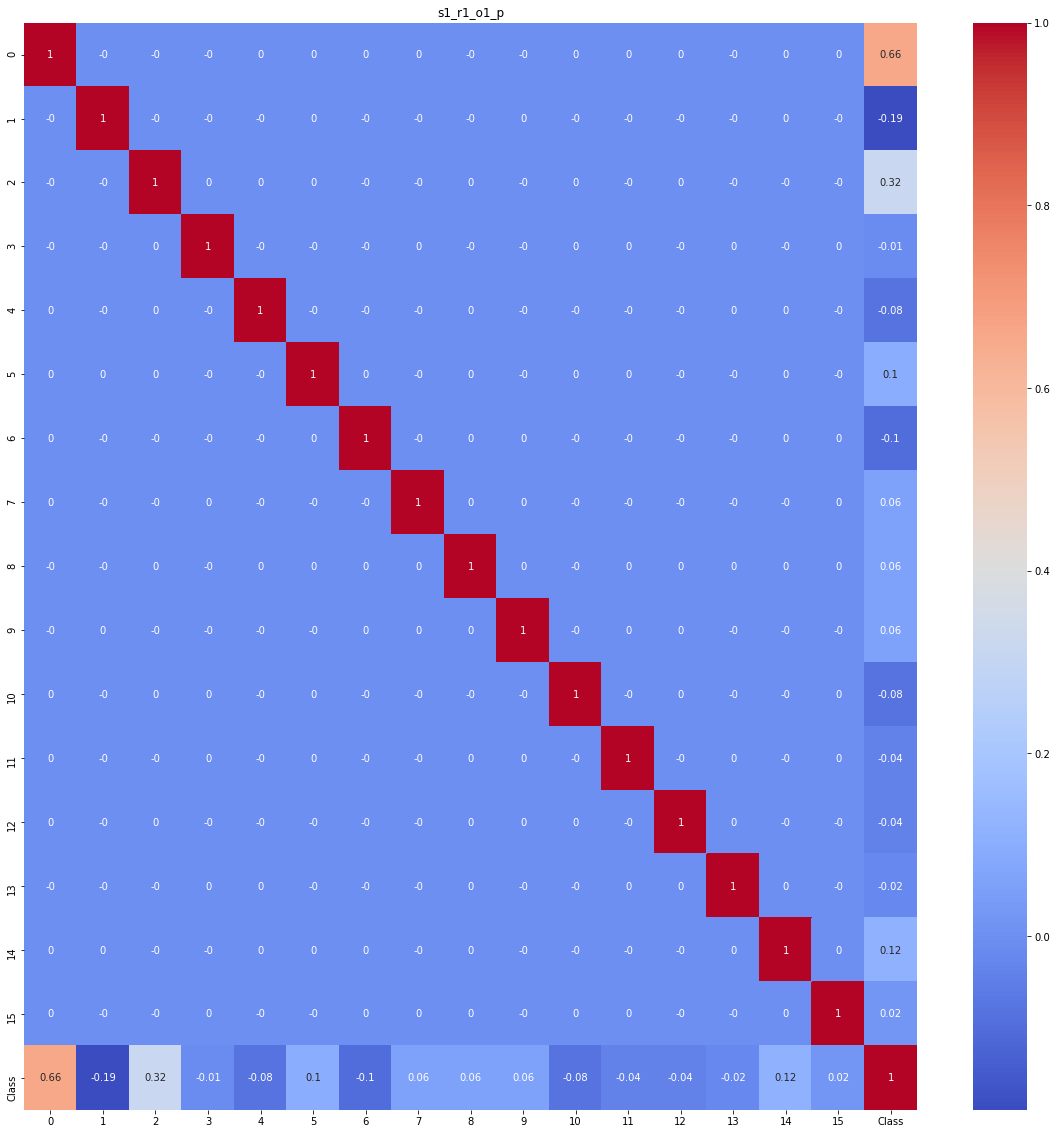

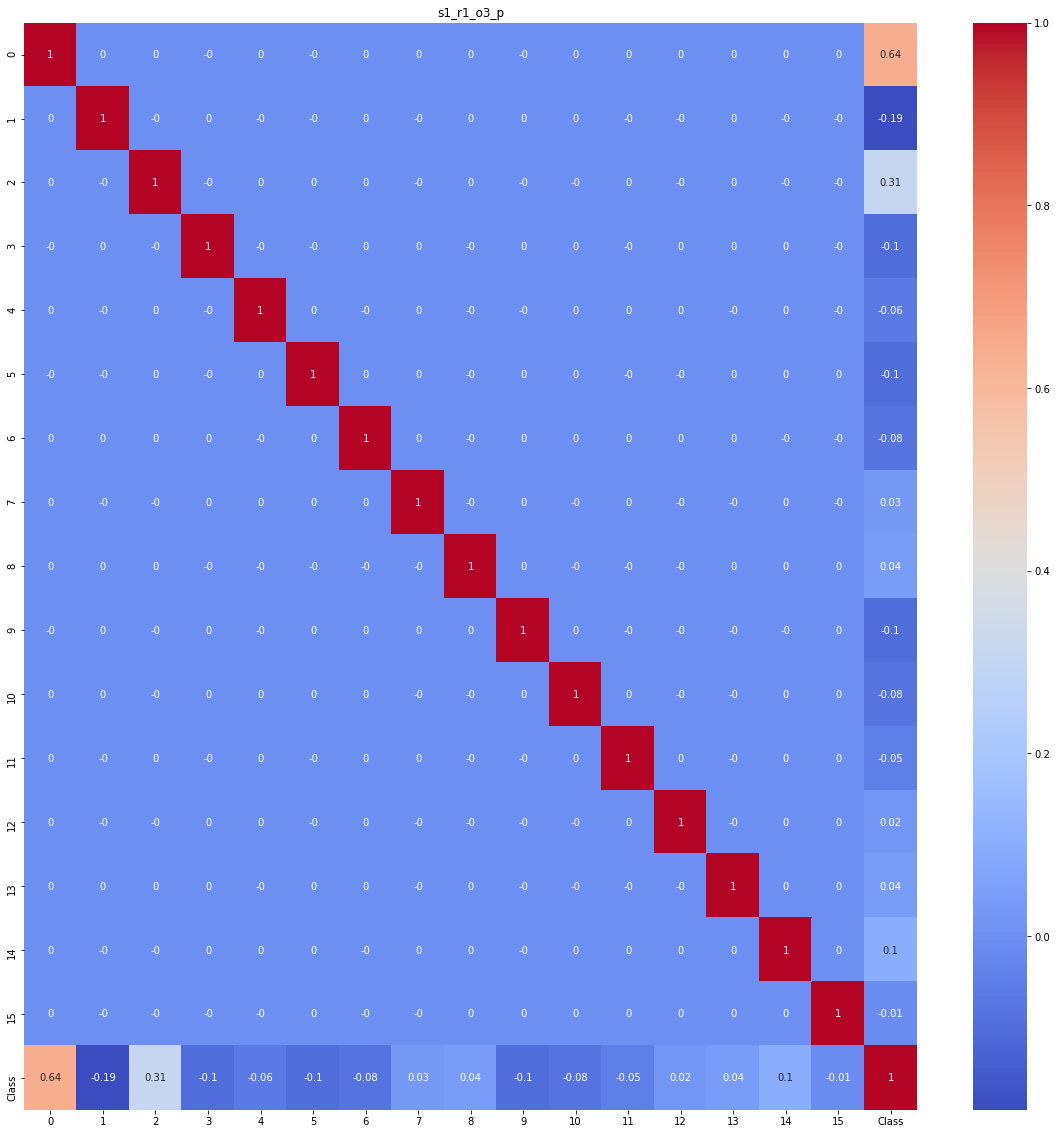

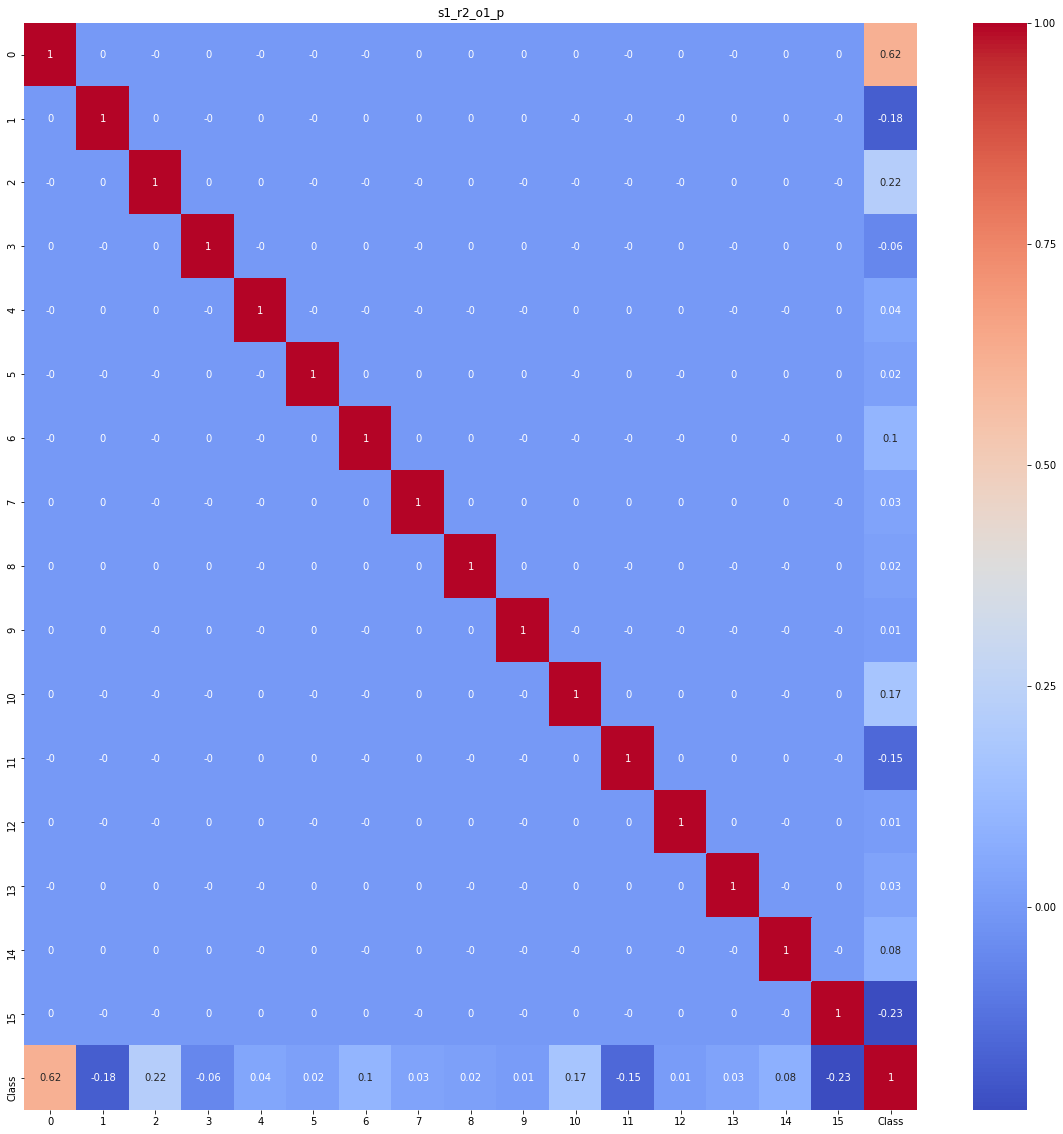

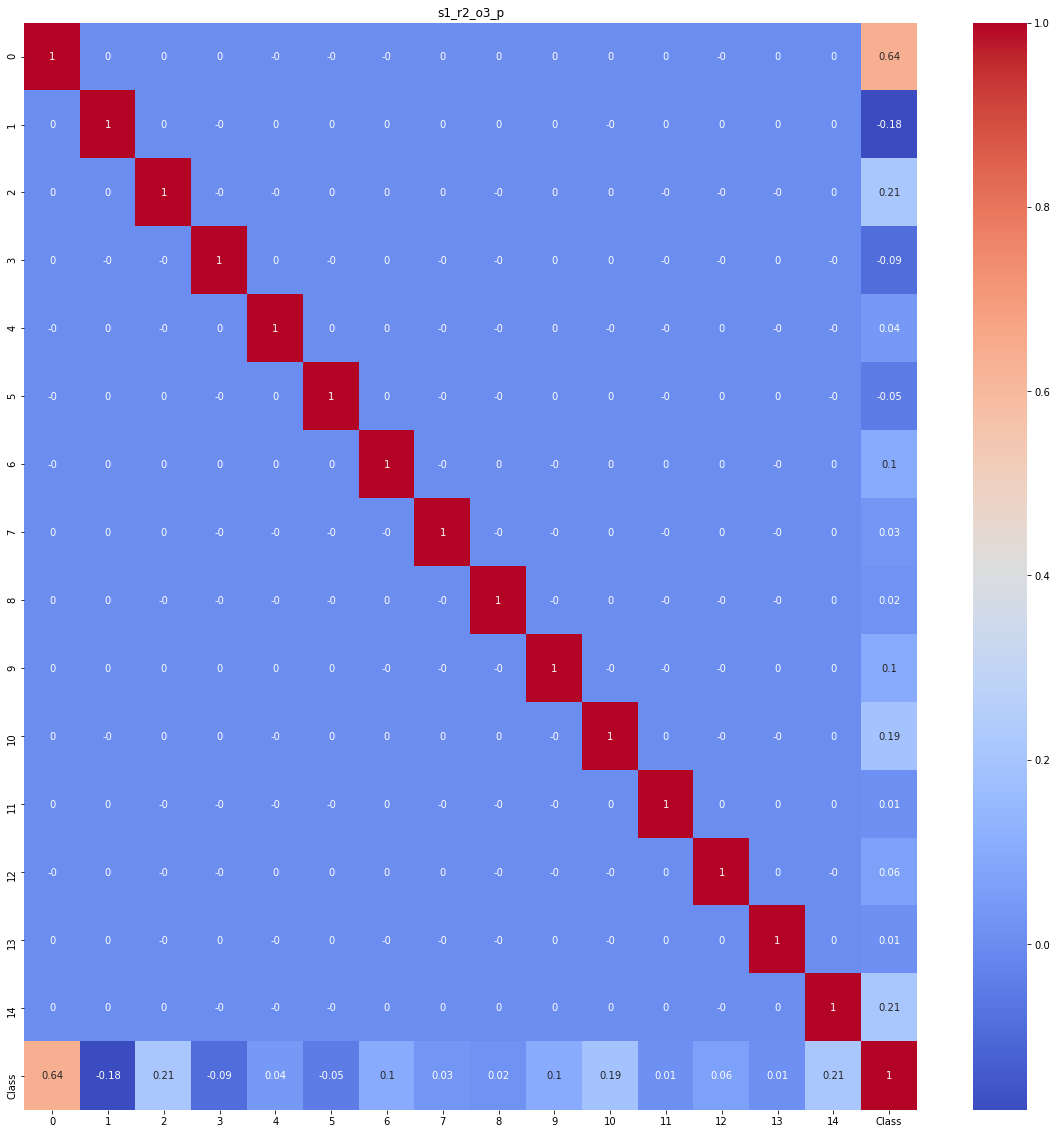

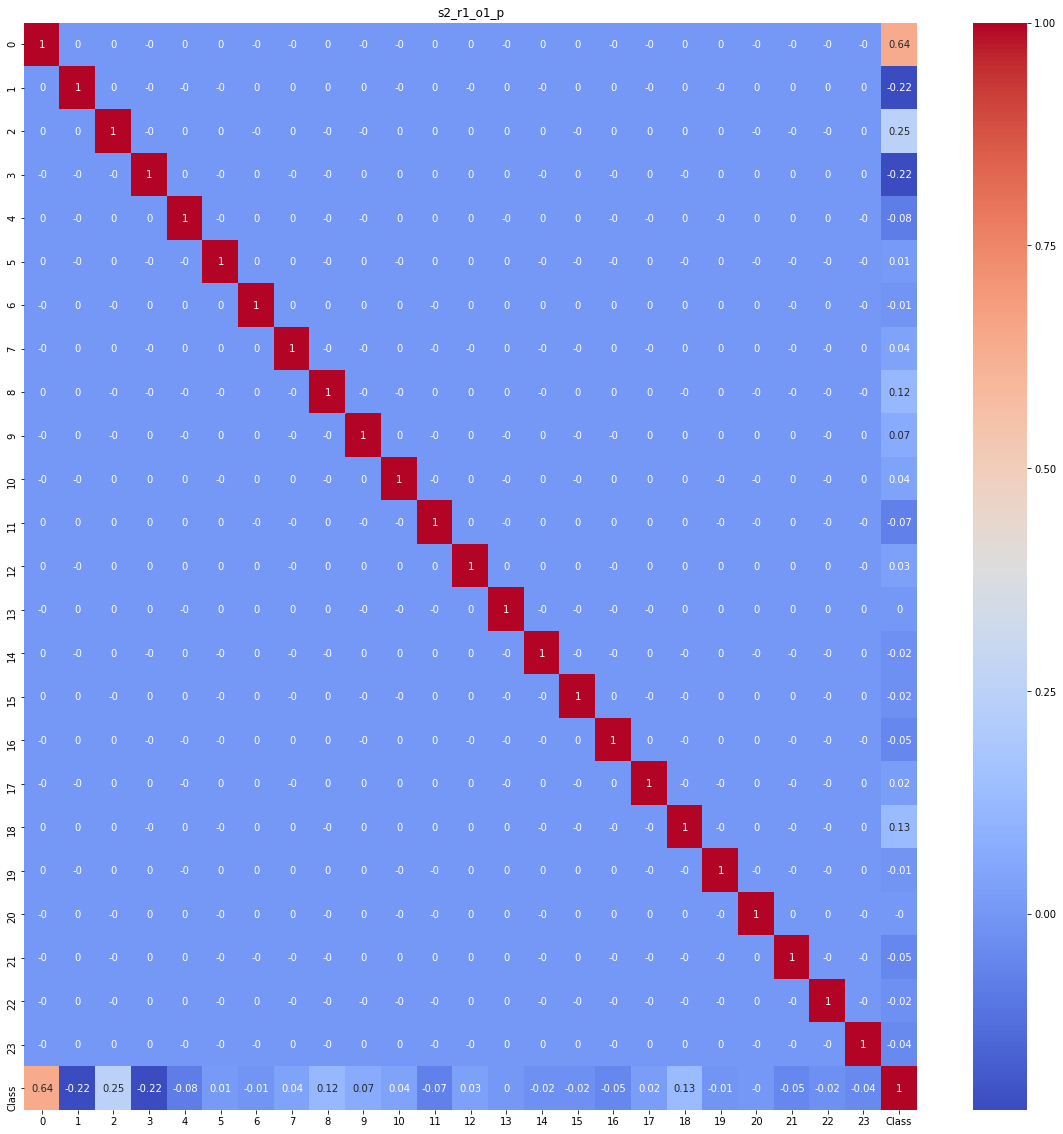

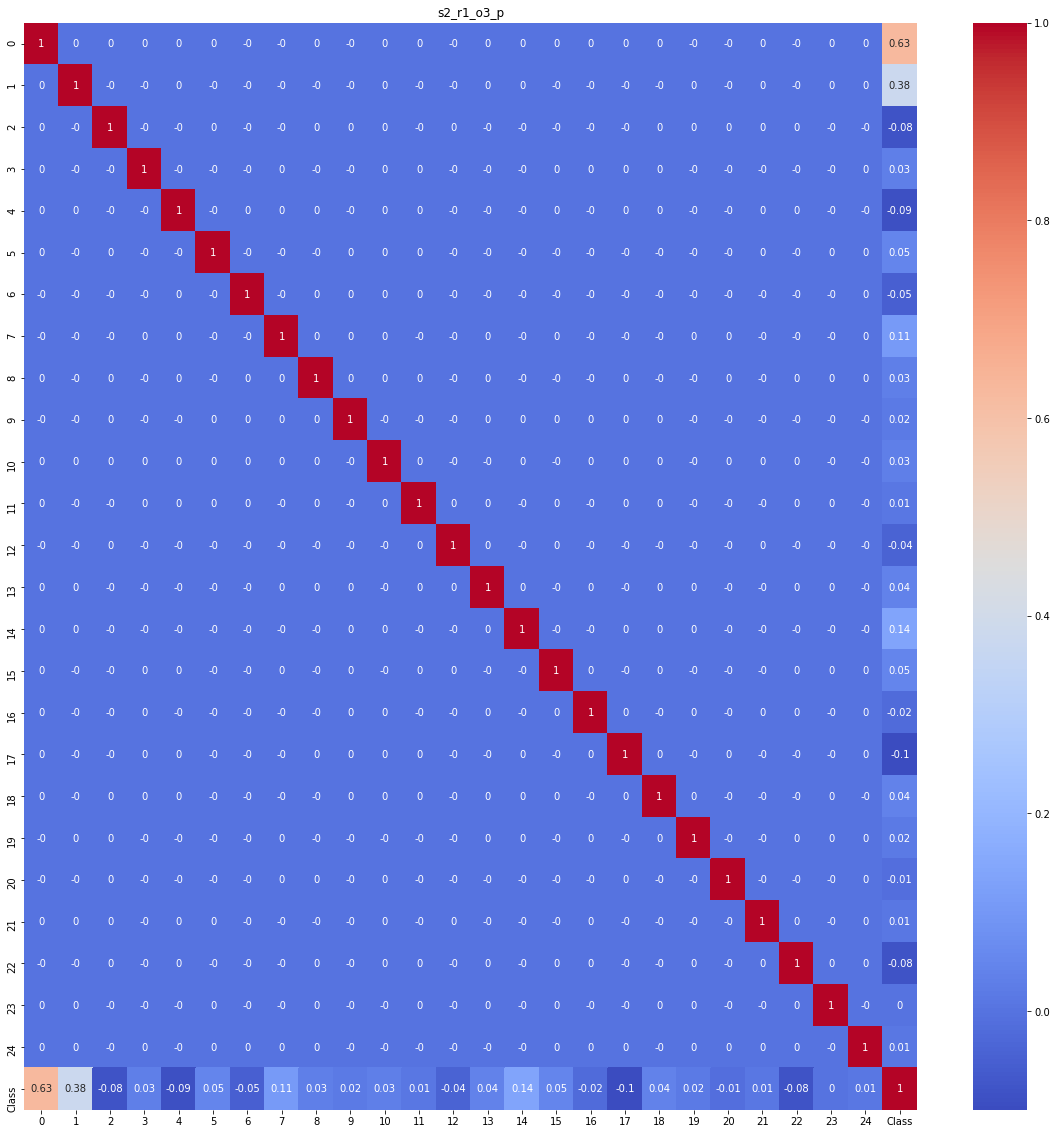

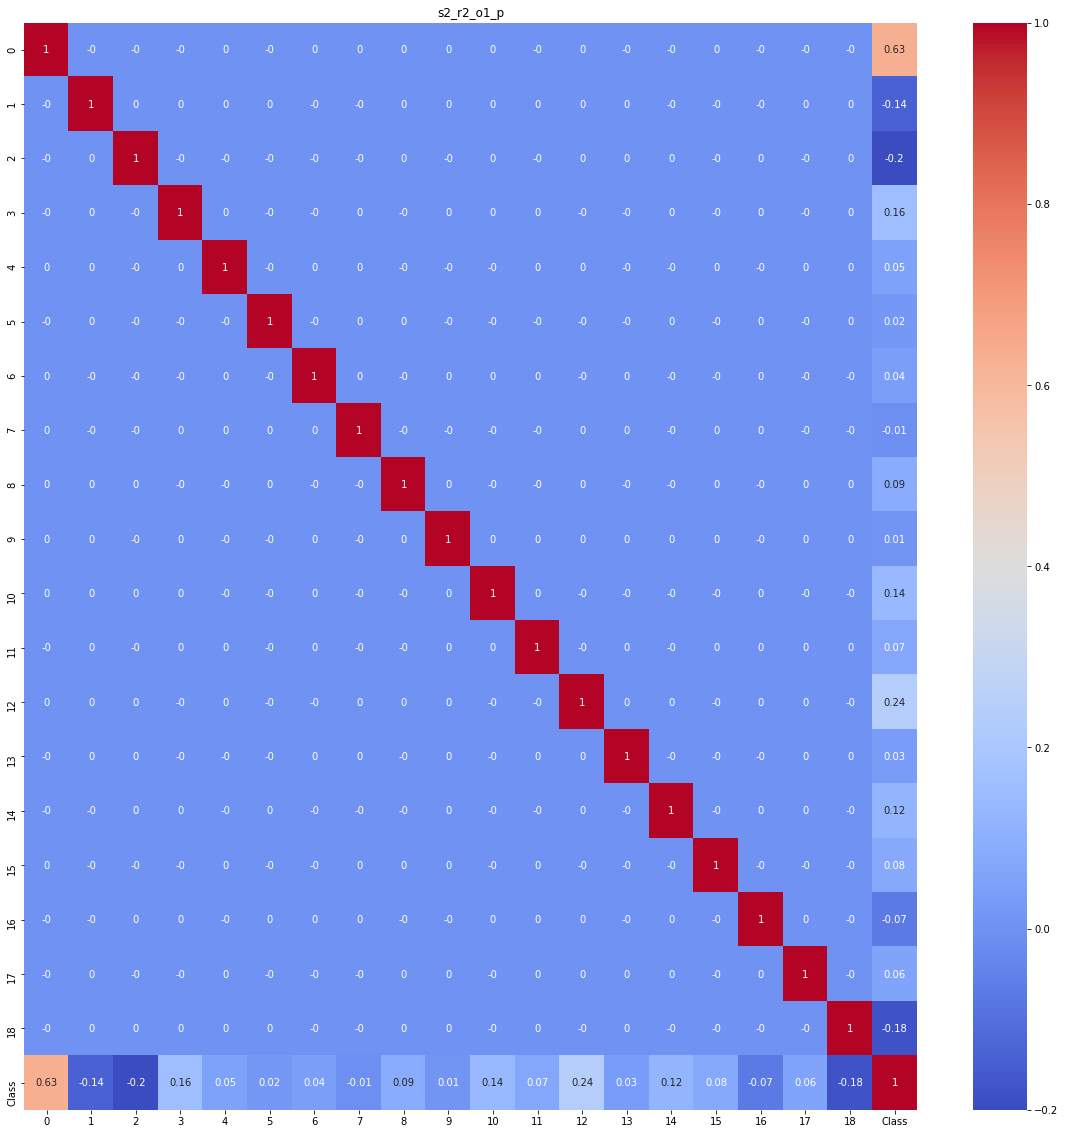

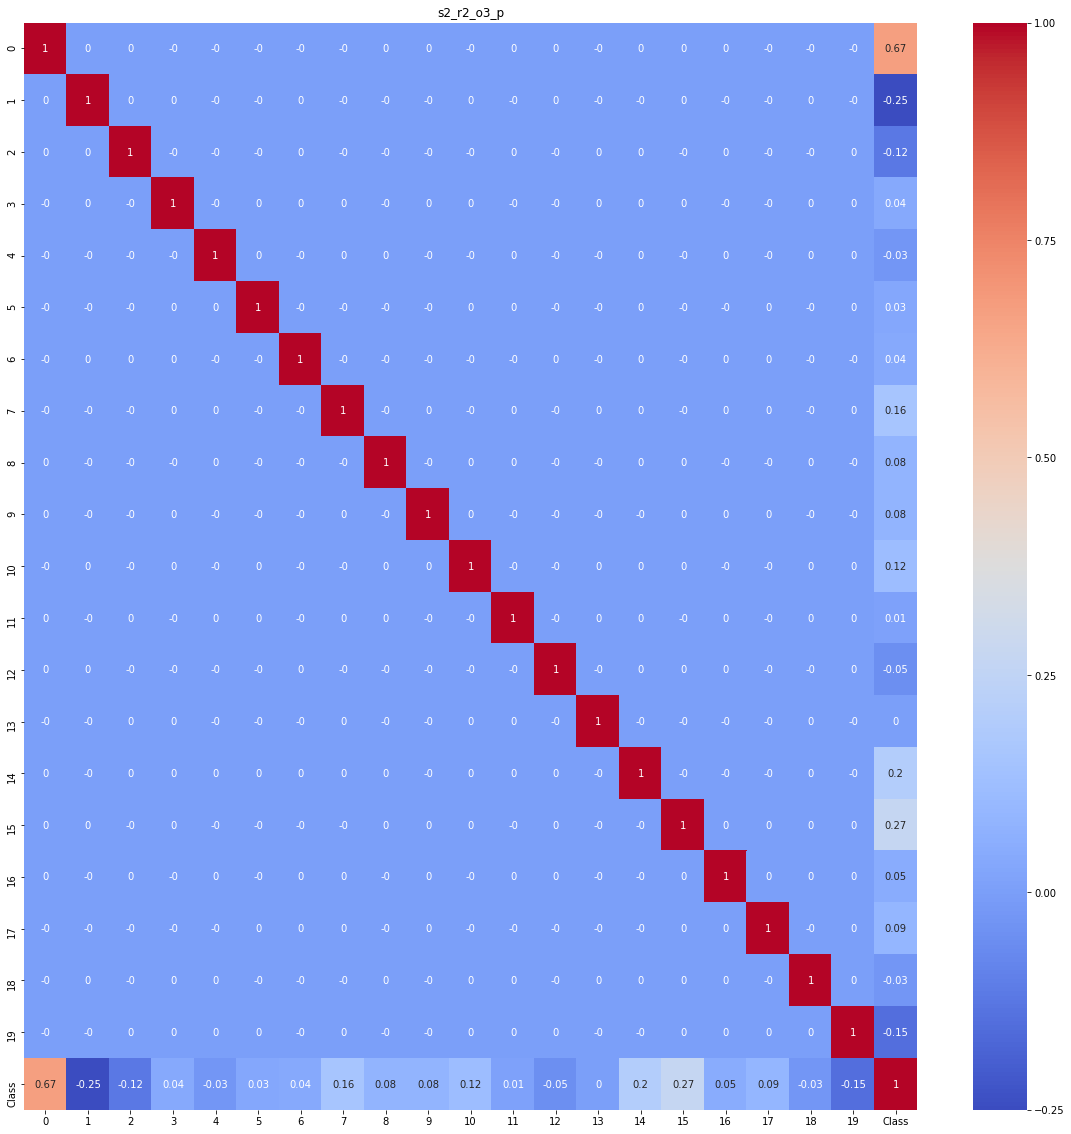

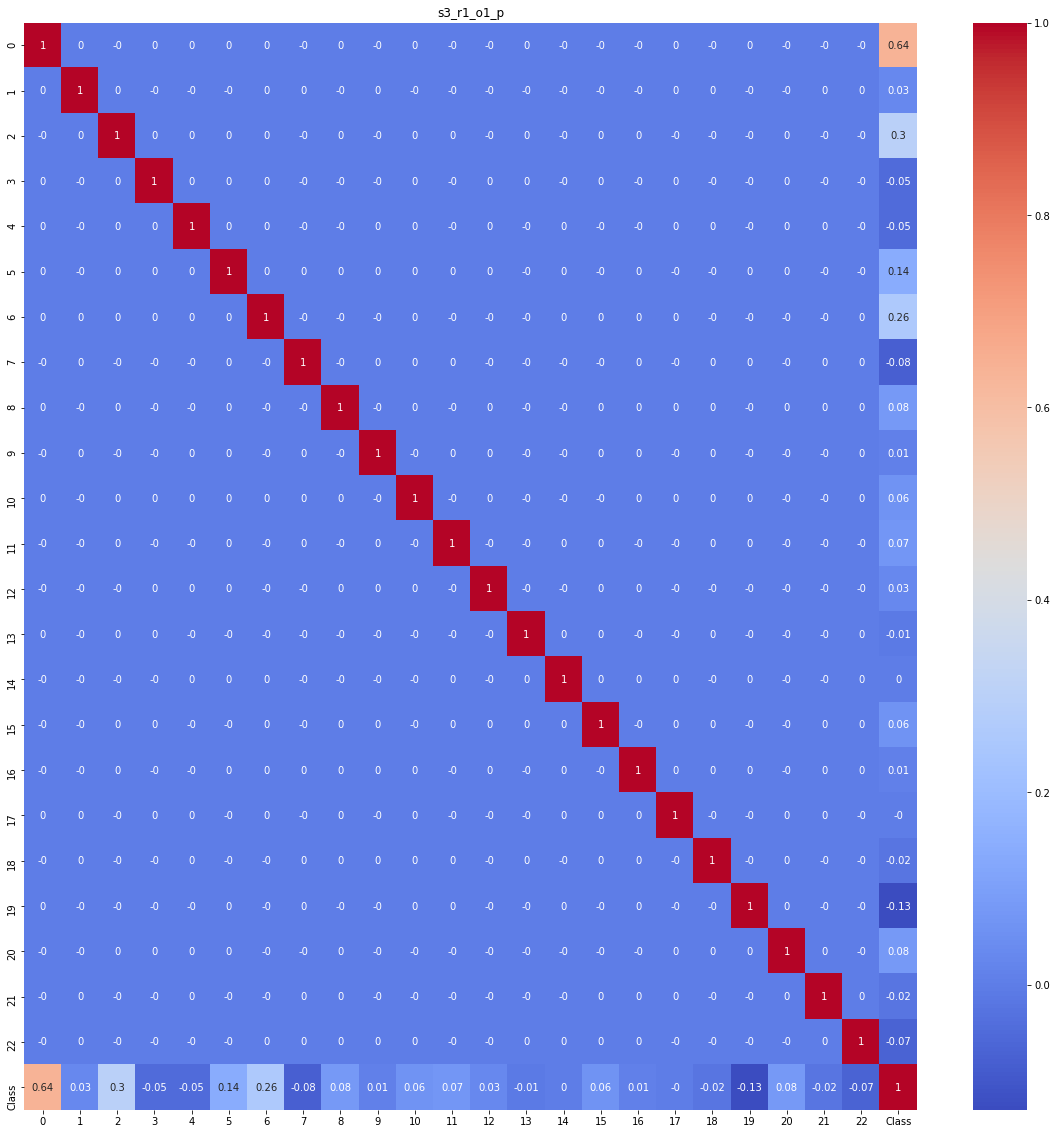

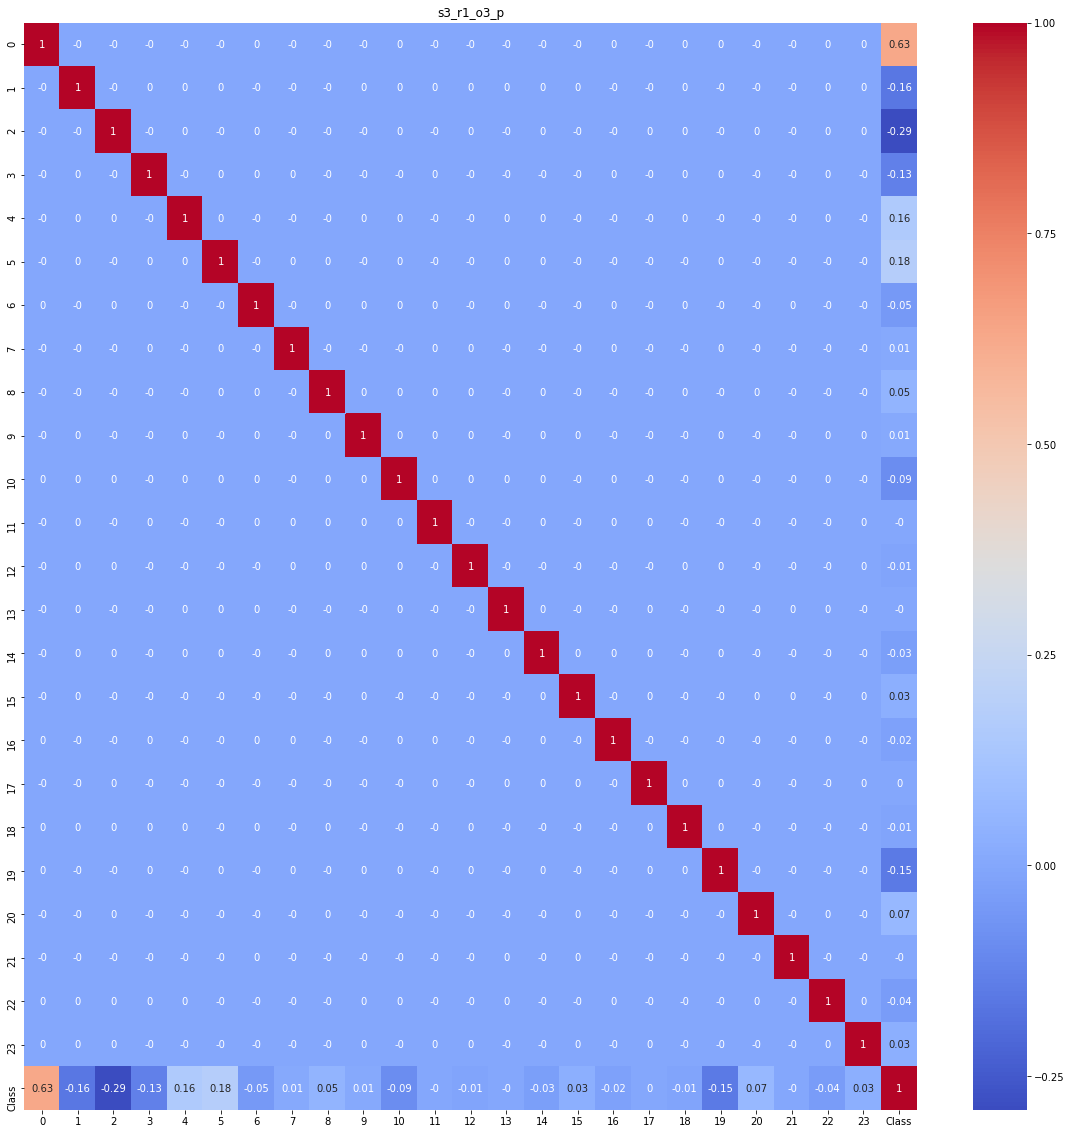

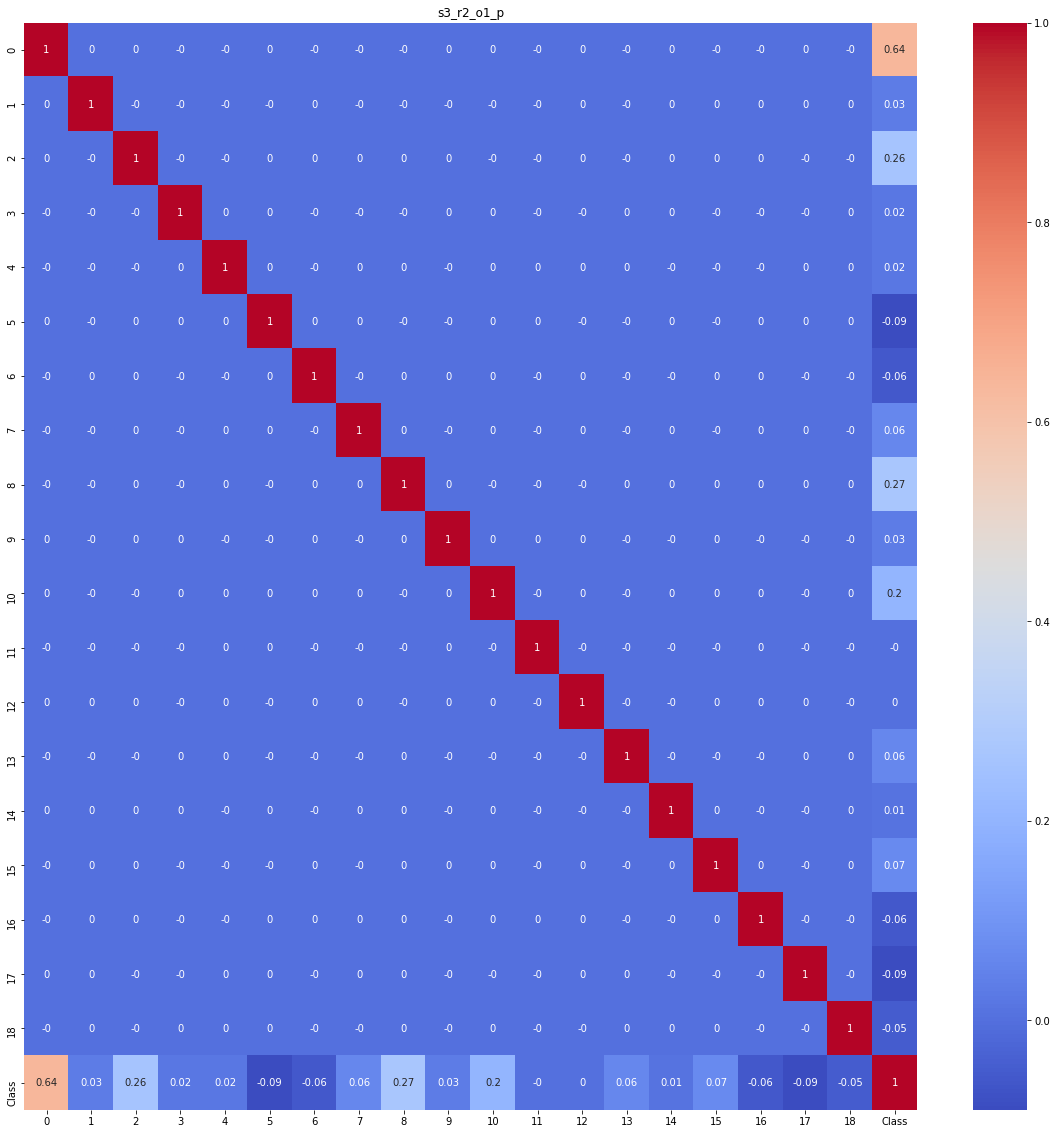

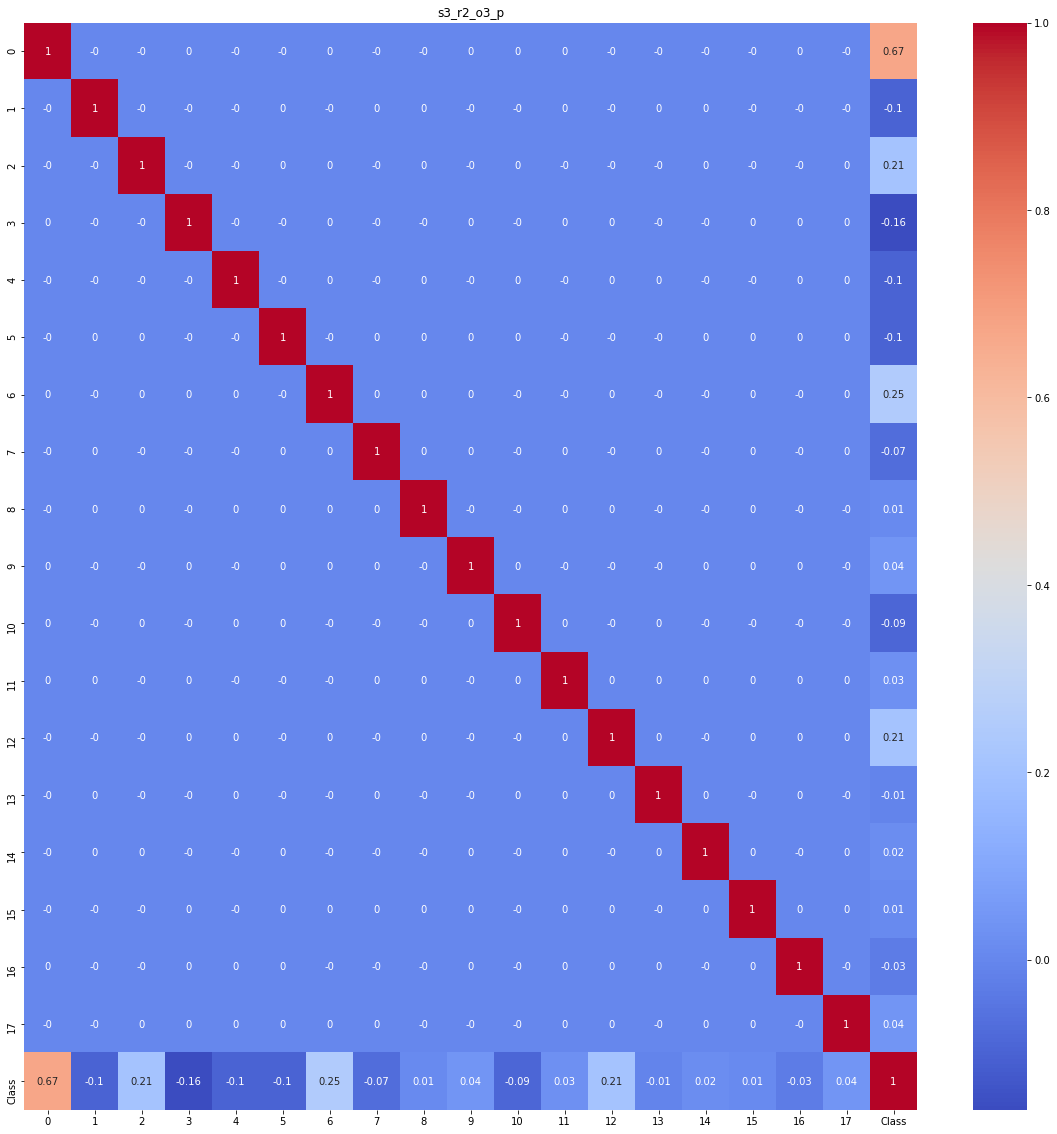

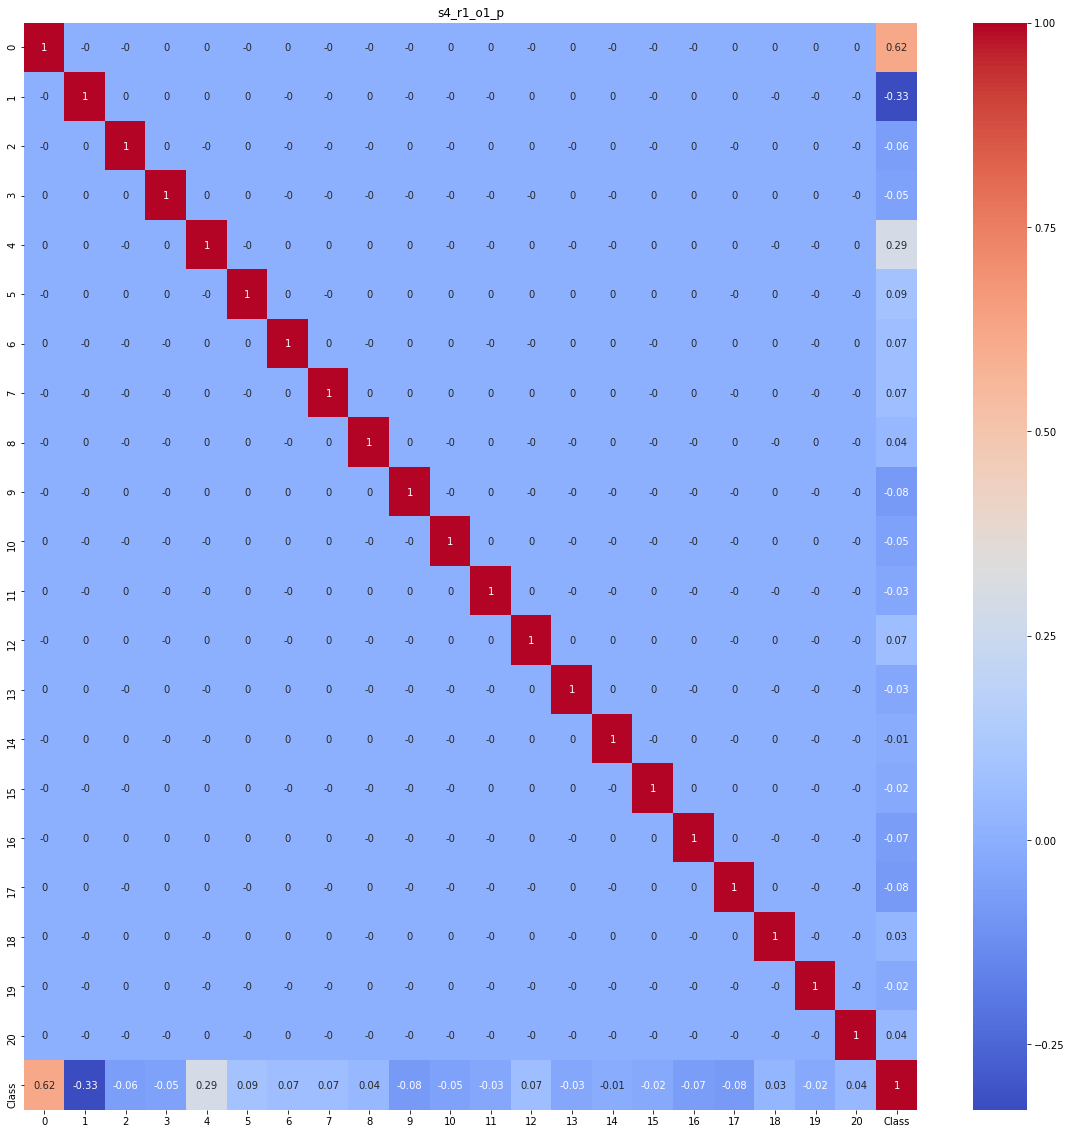

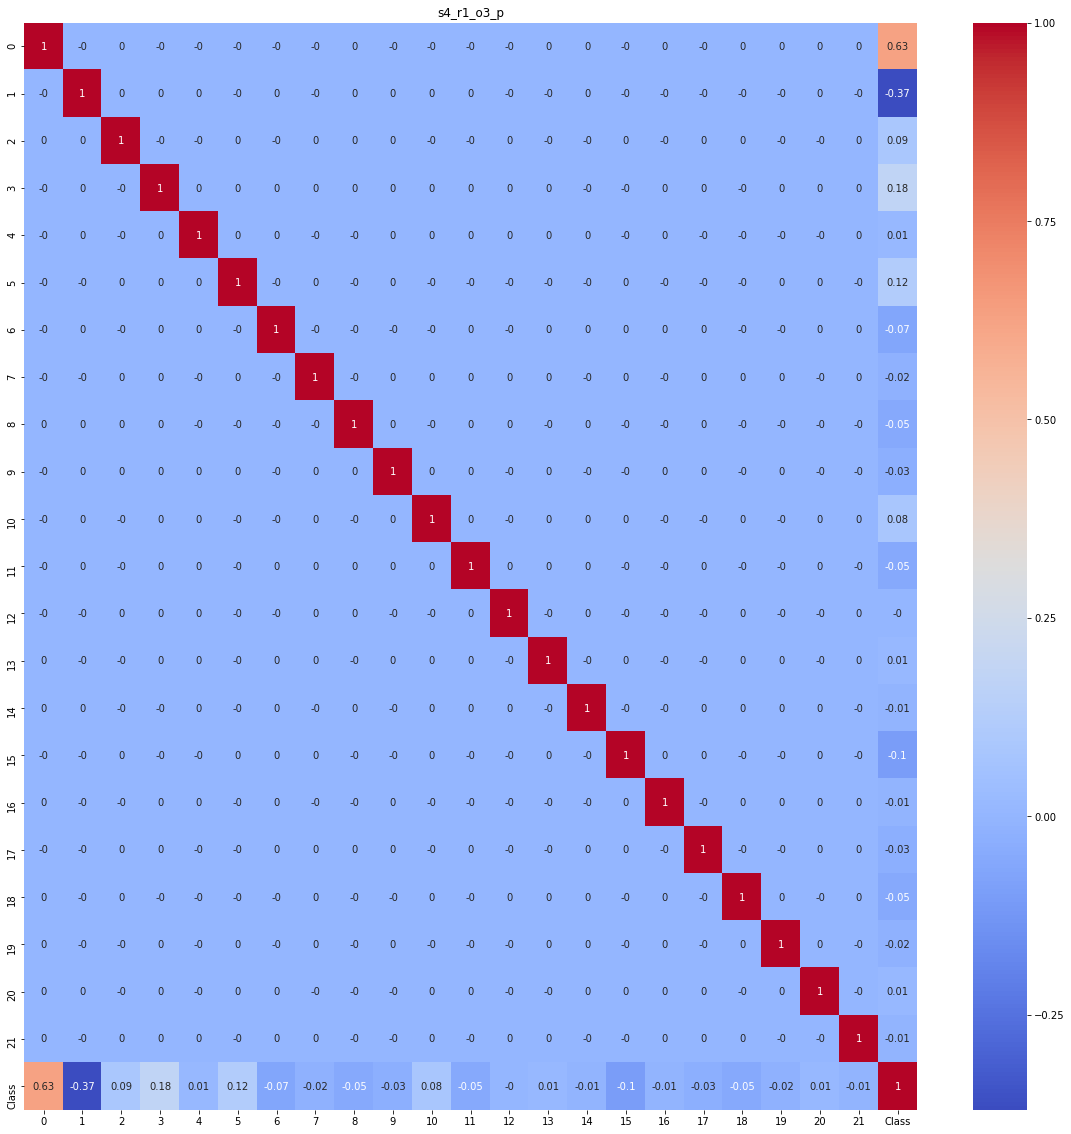

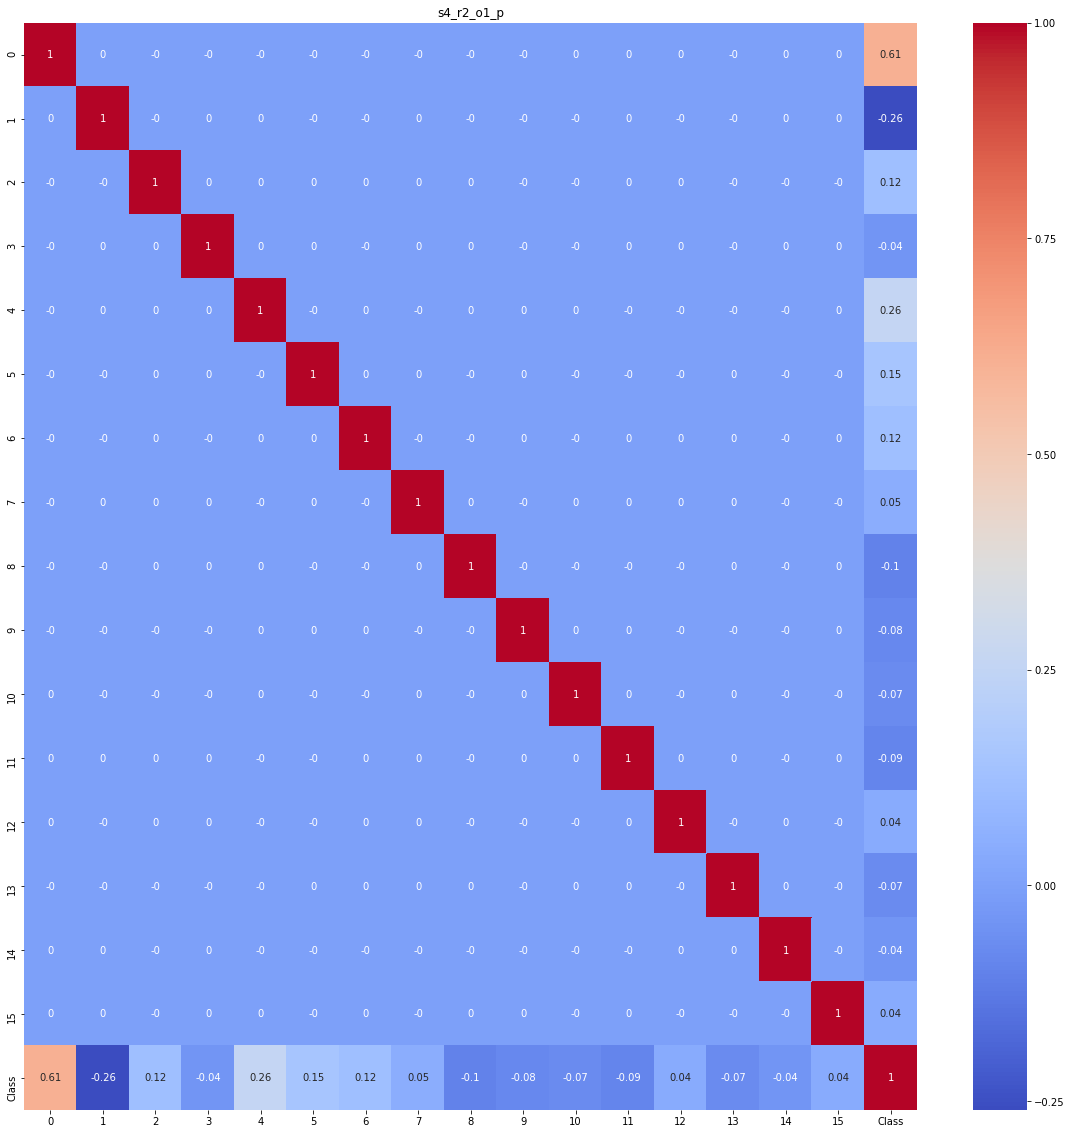

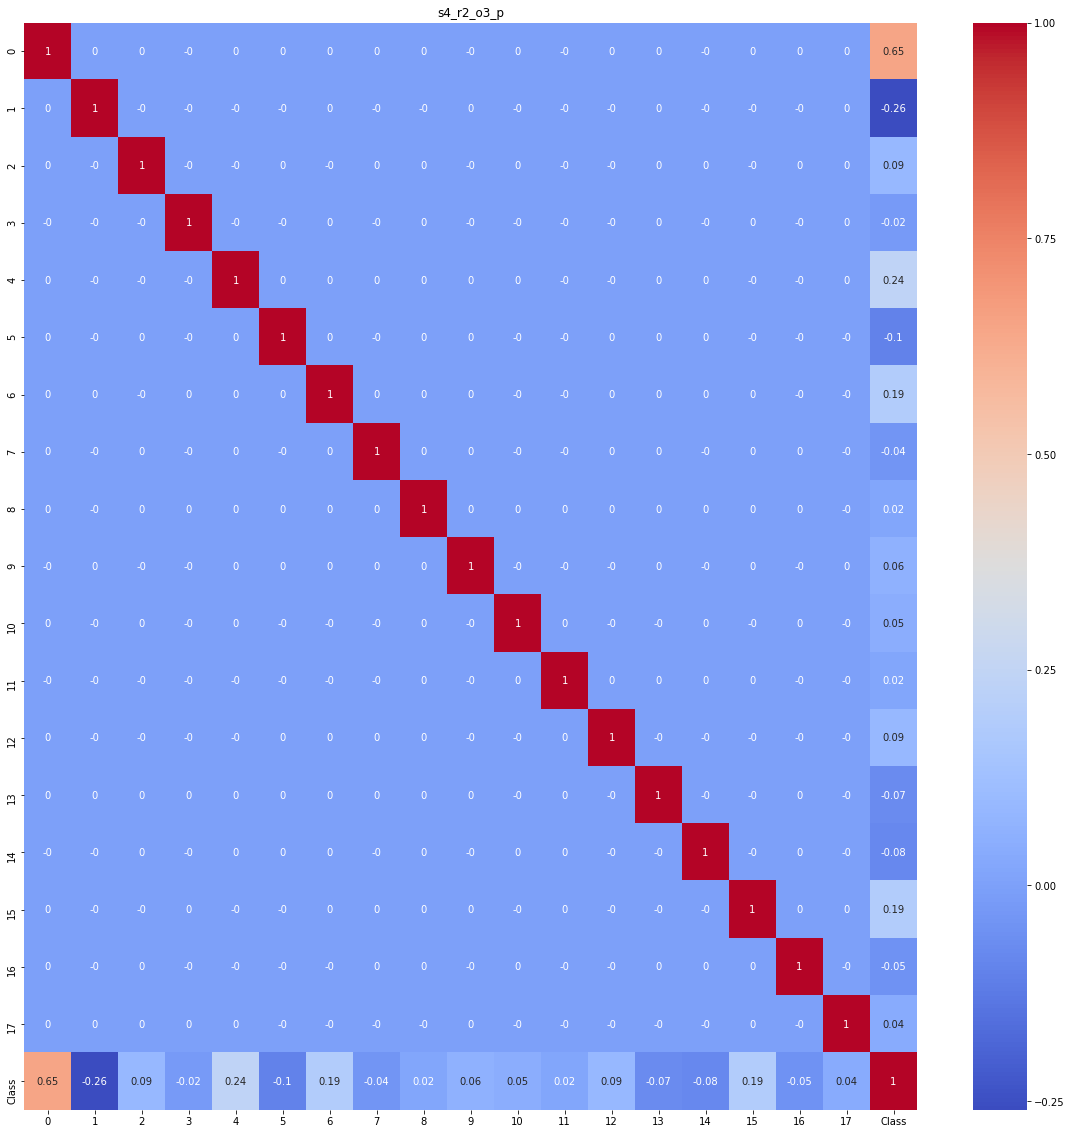

In [28]:
# Draw heat map for each version of the data with PCA
for key in sorted(pc_data.keys()):
    # Function from earlier to draw heat maps
    drawHeatMap(pc_data, key)

PCA removed all multicolinearity from the data and also lowered dimensionality!

## Sources
1) Stack Exchange post: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification<br>
2) Top Rated Kaggle Post: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets<br>
3) Scikit Learn Page: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html<br>
4) Microsoft Page on SMOTE: https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote<br>
5) GeeksForGeeks Page on NearMiss: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/ <br>
6) Blog Post on Removing Outliers: 'https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba